# Import libraries and data

In [363]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from matplotlib_venn import venn2, venn3
from scipy.stats import mannwhitneyu
from sklearn.metrics import ConfusionMatrixDisplay
from utils import get_uniprot, increase_stringency_CSF, print_p_val

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [364]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Brain proteome (HPA)

In [365]:
brain_detected = pd.read_csv(data_path + "Brain/Brain_detected.csv")
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")
brain_exclusive = pd.read_csv(data_path + "Brain/Brain_exclusive.csv")

## Feature data sets

### Unfiltered

In [366]:
# all human proteins
df_all = pd.read_csv(data_path + "/Features/df_features.csv")
print(len(df_all))

20303


### MS filtered

In [367]:
# all human proteins
df = pd.read_csv(data_path + "/Features/df_features_MS_filtered.csv")
# all proteins detected in brain
df_detected = pd.read_csv(data_path + "/Features/df_features_brain_detected_MS_filtered.csv")
# all proteins detected in brain that were not part of the training and testing (i.e. brain elevated) set
df_val = pd.read_csv(data_path + "/Features/df_features_brain_detected_val_MS_filtered.csv")
# all proteins elevated in brain
df_elevated = pd.read_csv(data_path + "/Features/df_features_brain_elevated_MS_filtered.csv")

In [368]:
# drop non-sequence-based features
df.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

# drop AA physicochemical features
df.drop(['Polar', 'Neutral', 'Hydrophobic', 'Volume_small', 'Volume_medium', 'Volume_large', 'Polarity_low', 
    'Polarity_medium', 'Polarity_large', 'Polarizability_low', 'Polarizability_medium', 'Polarizability_large',
    'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried', 'Exposed', 'Intermediate'], 
    axis=1, inplace=True)

## CSF

In [369]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

## Marker proteins

### BIONDA

In [370]:
dementia_markers_BIONDA = pd.read_csv(data_path + "/Biomarker_discovery/BIONDA_dementia_markers.csv", sep=";")
ND_markers = pd.read_csv(data_path + "/Biomarker_discovery/BIONDA_ND_markers.csv", sep=";") # neurodegenerative disease

### DisGeNet

In [371]:
AD_markers = pd.read_csv(data_path + "/Biomarker_discovery/DisGeNet_AD_markers.tsv", sep="\t")
dementia_markers = pd.read_csv(data_path + "/Biomarker_discovery/DisGeNet_dementia_markers.tsv", sep="\t")

## Bai et al. (2020)

Deep Multilayer Brain Proteomics Identifies Molecular Networks in Alzheimer’s Disease Progression: https://doi.org/10.1016/j.neuron.2019.12.015

In [372]:
Bai2020_brain = pd.read_csv(data_path + "/Biomarker_discovery/Bai2020_protein_list_brain_tissue.txt", header=None, 
    names=["Uniprot"])
Bai2020_brain_biomarkers = pd.read_csv(data_path + "/Biomarker_discovery/Bai2020_protein_list_brain_tissue_biomarker_candidates.txt", 
    header=None, names=["Uniprot"])
Bai2020_CSF = pd.read_csv(data_path + "/Biomarker_discovery/Bai2020_protein_list_CSF.txt", header=None, names=["Uniprot"])
Bai2020_CSF_biomarkers = pd.read_csv(data_path + "/Biomarker_discovery/Bai2020_protein_list_CSF_biomarker_candidates.txt", 
    header=None, names=["Uniprot"])


Bai2020_brain["Uniprot"] = Bai2020_brain["Uniprot"].apply(get_uniprot)
Bai2020_brain_biomarkers["Uniprot"] = Bai2020_brain_biomarkers["Uniprot"].apply(get_uniprot)
Bai2020_CSF["Uniprot"] = Bai2020_CSF["Uniprot"].apply(get_uniprot)
Bai2020_CSF_biomarkers["Uniprot"] = Bai2020_CSF_biomarkers["Uniprot"].apply(get_uniprot)

## Higginbotham et al. (2020)

Integrated proteomics reveals brain-based cerebrospinal fluid biomarkers in asymptomatic and symptomatic Alzheimer’s disease: https://doi.org/10.1126/sciadv.aaz9360

In [373]:
def get_uniprot_alt(string):
    _, uniprot = string.split("|")
    
    if "-" in uniprot:
        uniprot, _ = uniprot.split("-")

    return uniprot

In [374]:
Higginbotham2020_brain = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_brain.txt", header=None, 
    names=["Uniprot"])
Higginbotham2020_CSF = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_CSF.txt", 
    header=None, names=["Uniprot"])

In [375]:
Higginbotham2020_brain["Uniprot"] = Higginbotham2020_brain["Uniprot"].apply(get_uniprot_alt)
Higginbotham2020_CSF["Uniprot"] = Higginbotham2020_CSF["Uniprot"].apply(get_uniprot_alt)

## Biomarker list (Nerea, MIRIADE)

In [376]:
biomarkers_Nerea = pd.read_csv(data_path + "/Biomarker_discovery/Biomarkers_MIRIADE_Nerea.tsv", sep="\t", header=0, 
    names=["Uniprot", "Gene name", "Protein name"])
biomarkers_Nerea

,Uniprot,Gene name,Protein name
0,Q9Y6Q6,TNFRSF11A,TNR11
1,Q9Y653,ADGRG1,AGRG1
2,Q9Y624,F11R,JAM1
3,Q9Y336,SIGLEC9,SIGL9
4,Q9Y2T3,GDA,GUAD
...,...,...,...
285,O00300,TNFRSF11B,TR11B
286,O00253,AGRP,AGRP
287,P02748,C9,CO9
288,P01011,SERPINA3,AACT


## Model and scaler

In [377]:
with open(os.getcwd() + "/Models/LogisticClassifier_L2.pkl", "rb") as f:  
    lr_l2 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_2plus.pkl", "rb") as f:  
    lr_l2_2plus = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_3plus.pkl", "rb") as f:  
    lr_l2_3plus = pickle.load(f)

In [378]:
with open(os.getcwd() + "/Models/LogisticClassifier_L1.pkl", "rb") as f:  
    lr_l1 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L1_2plus.pkl", "rb") as f:  
    lr_l1_2plus = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L1_3plus.pkl", "rb") as f:  
    lr_l1_3plus = pickle.load(f)

In [379]:
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "rb") as f:  
    scaler = pickle.load(f)

# Prediction

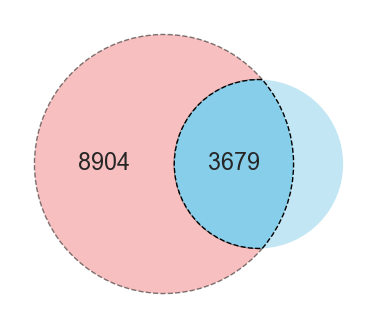

In [380]:
brain_detected_set = set(df_val["Uniprot"])
csf_set = set(csf["Uniprot"])

sns.set(style=("ticks"), font_scale=1.4)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
colors=("lightcoral", "skyblue")
alpha = 0.5

# entire dataset
v = venn2([brain_detected_set, csf_set], ["", ""], 
    set_colors=colors, alpha=alpha)
v.get_patch_by_id("11").set_color("skyblue")
v.get_patch_by_id("11").set_alpha(1.0)
v.get_patch_by_id("11").set_linestyle("dashed")
v.get_patch_by_id("11").set_edgecolor("black")
v.get_patch_by_id("10").set_linestyle("dashed")
v.get_patch_by_id("10").set_edgecolor("black")
v.get_label_by_id("01").set_text("")
plt.show()

plt.show()
fig.savefig(fig_path + "Venn_diagrams_overlap_brain_detected_CSF.png", bbox_inches="tight", dpi=300, transparent=True)
# 12583
# 8904 + 3679

In [381]:
# define continuous variables
# cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
#         'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Polar', 'Neutral', 'Hydrophobic', 'Volume_small', 
#         'Volume_medium', 'Volume_large', 'Polarity_low', 'Polarity_medium', 'Polarity_large', 'Polarizability_low', 
#         'Polarizability_medium', 'Polarizability_large', 'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried',
#         'Exposed', 'Intermediate', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA', 
#         'First60ExpAA', 'PredHel', 'Glycosylation']

cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 
        'Solubility', 'ExpAA', 'First60ExpAA', 'PredHel', 'Glycosylation']

In [382]:
# define variables and target
X = df.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df["CSF"]

# preprocess data with same scaler as training data
X_scal = X.copy()
X_scal[cont] = scaler.transform(X_scal[cont])

# lr_l2.classes_ # -1 and 1

In [383]:
print("Number of features:", len(X.columns))

Number of features: 55


In [384]:
lr_l2.feature_names_in_

array(['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H',
       'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
       'Isoelectric point', 'Instability index', 'Disorder_NSP',
       'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA',
       'First60ExpAA', 'PredHel', 'PredHel_binary', 'Cytoplasm',
       'Extracellular', 'Lysosome/Vacuole', 'Nucleus', 'Cell_membrane',
       'Endoplasmic_reticulum', 'Mitochondrion', 'Golgi_apparatus',
       'Peroxisome', 'Plastid', 'PS00232', 'PS00237', 'PS00027',
       'PS00028', 'PS00022', 'PS01186', 'Glycosylation', 'GlycoMine_N',
       'GlycoMine_O', 'GlycoMine_C', 'GPI-anchor', 'Signal peptide'],
      dtype=object)

In [385]:
X_scal.columns

Index(['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
       'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
       'Isoelectric point', 'Instability index', 'Solubility', 'Disorder_NSP',
       'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Signal peptide', 'Glycosylation',
       'GlycoMine_N', 'GlycoMine_O', 'GlycoMine_C', 'Cytoplasm',
       'Extracellular', 'Lysosome/Vacuole', 'Nucleus', 'Cell_membrane',
       'Endoplasmic_reticulum', 'Mitochondrion', 'Golgi_apparatus',
       'Peroxisome', 'Plastid', 'ExpAA', 'First60ExpAA', 'PredHel',
       'PredHel_binary', 'GPI-anchor', 'PS00232', 'PS00237', 'PS00027',
       'PS00028', 'PS00022', 'PS01186'],
      dtype='object')

In [386]:
X_scal = X_scal[['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H',
       'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
       'Isoelectric point', 'Instability index', 'Disorder_NSP',
       'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA',
       'First60ExpAA', 'PredHel', 'PredHel_binary', 'Cytoplasm',
       'Extracellular', 'Lysosome/Vacuole', 'Nucleus', 'Cell_membrane',
       'Endoplasmic_reticulum', 'Mitochondrion', 'Golgi_apparatus',
       'Peroxisome', 'Plastid', 'PS00232', 'PS00237', 'PS00027',
       'PS00028', 'PS00022', 'PS01186', 'Glycosylation', 'GlycoMine_N',
       'GlycoMine_O', 'GlycoMine_C', 'GPI-anchor', 'Signal peptide']]

In [387]:
df_pred = df.copy()
models = [lr_l2, lr_l2_2plus, lr_l2_3plus, lr_l1, lr_l1_2plus, lr_l1_3plus]
model_names = ["lr_l2", "lr_l2_2plus", "lr_l2_3plus", "lr_l1", "lr_l1_2plus", "lr_l1_3plus"]
# models = [svc_l2, svc_l2_2plus, svc_l2_3plus]
# model_names = ["svc_l2", "svc_l2_2plus", "svc_l2_3plus"]

for i, m in enumerate(models):
    # calculate probabilities with trained model
    proba = m.predict_proba(X_scal)
#     proba = m.decision_function(X_scal)
    # create dataframe of probabilities
    preds = pd.DataFrame(proba, columns=["non_CSF_proba", "CSF_proba"])
    column_name = model_names[i]
    df_pred[column_name] = preds["CSF_proba"]

# order dataframe by probabilities
df_pred.sort_values(by="lr_l2", ascending=False, inplace=True)
# reindex to see protein rank according to probability
df_pred.reset_index(drop=True, inplace=True)

df_pred

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.



,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PS00028,PS00022,PS01186,CSF,lr_l2,lr_l2_2plus,lr_l2_3plus,lr_l1,lr_l1_2plus,lr_l1_3plus
0,Q7Z5P9,MKLILWYLVVALWCFFKDVEALLYRQKSDGKIAASRSGGFSYGSSS...,8384,805243.2713,0.084566,0.015983,0.018488,0.054031,0.014671,0.176885,...,0,0,0,1,0.999814,0.969888,0.847058,0.996829,0.883515,0.402296
1,P15502,MAGLTAAAPRPGVLLLLLSILHPSRPGGVPGAIPGGVPGGVFYPGA...,786,68396.5989,0.212468,0.002545,0.003817,0.006361,0.020356,0.286260,...,0,0,0,1,0.999805,0.999405,0.998764,0.982049,0.999382,0.998586
2,Q8TDW7,MDIIMGHCVGTRPPACCLILLLFKLLATVSQGLPGTGPLGFHFTHS...,4557,501972.1349,0.054641,0.013386,0.074172,0.060347,0.041914,0.064077,...,0,1,1,1,0.998578,0.734875,0.570439,0.982608,0.581590,0.178573
3,Q02817,MGLPLARLAAVCLALSLAGGSELQTEGRTRYHGRNVCSTWGNFHYK...,5179,540293.7725,0.023170,0.041514,0.025681,0.026067,0.014868,0.054644,...,0,0,0,-1,0.998343,0.806401,0.871989,0.980952,0.730539,0.665975
4,Q9NYQ8,MTIALLGFAIFLLHCATCEKPLEGILSSSAWHFTHSHYNATIYENS...,4349,479311.4528,0.061853,0.012417,0.063693,0.061623,0.038400,0.065532,...,0,1,1,1,0.997582,0.676151,0.468425,0.974411,0.444930,0.106325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16751,P09017,MIMSSYLMDSNYIDPKFPPCEEYSQNSYIPEHSPEYYGRTRESGFQ...,264,29810.8868,0.075758,0.018939,0.022727,0.068182,0.015152,0.045455,...,0,0,0,-1,0.009423,0.053709,0.080796,0.087097,0.096818,0.201572
16752,P0C646,MGIPGLEGLHTWISIPFSFMYIVAVAGNIFLIFLIMTERSLHEPMY...,298,33381.8275,0.083893,0.036913,0.016779,0.016779,0.087248,0.050336,...,0,0,0,-1,0.009197,0.002834,0.000370,0.043436,0.017823,0.010790
16753,Q96LW7,MTDQTYCDRLVQDTPFLTGHGRLSEQQVDRIILQLNRYYPQILTNK...,228,25589.1823,0.070175,0.035088,0.030702,0.026316,0.030702,0.048246,...,0,0,0,-1,0.008791,0.013976,0.007040,0.024666,0.029855,0.033331
16754,Q6P5X5,MCRCSLVLLSVDHEVPFSSFFIGWRTEGRAWRAGRPDMADGSGWQP...,142,16804.7576,0.098592,0.049296,0.049296,0.091549,0.028169,0.042254,...,0,0,0,-1,0.005251,0.011083,0.012235,0.020229,0.021683,0.079643


### Charlotte's biomarker candidates

In [388]:
df_pred[df_pred["Uniprot"] == "Q8IV35"][['Disorder_NSP', 'Helix_NSP', 'Turn_NSP',
       'Sheet_NSP', 'Solubility', 'ExpAA', 'First60ExpAA', 'PredHel',
       'PredHel_binary', 'Cytoplasm', 'Extracellular', 'Lysosome/Vacuole',
       'Nucleus', 'Cell_membrane', 'Endoplasmic_reticulum', 'Mitochondrion',
       'Golgi_apparatus', 'Peroxisome', 'Plastid']]
# WDR49

,Disorder_NSP,Helix_NSP,Turn_NSP,Sheet_NSP,Solubility,ExpAA,First60ExpAA,PredHel,PredHel_binary,Cytoplasm,Extracellular,Lysosome/Vacuole,Nucleus,Cell_membrane,Endoplasmic_reticulum,Mitochondrion,Golgi_apparatus,Peroxisome,Plastid
10379,0.294118,0.021521,0.642755,0.335725,0.581367,9.44,4.52,0.0,0,0,0,0,0,0,0,1,0,0,0


In [389]:
df_pred[df_pred["Uniprot"] == "Q8IV35"][['PS00232', 'PS00237',
       'PS00027', 'PS00028', 'PS00022', 'PS01186', 'Glycosylation',
       'GlycoMine_N', 'GlycoMine_O', 'GlycoMine_C', 'GPI-anchor',
       'Signal peptide']]

,PS00232,PS00237,PS00027,PS00028,PS00022,PS01186,Glycosylation,GlycoMine_N,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide
10379,0,0,0,0,0,0,0.0,0,0,0,0,0


In [390]:
df_pred[df_pred["Uniprot"] == "Q8IV35"][['CSF', 'lr_l2',
       'lr_l2_2plus', 'lr_l2_3plus', 'lr_l1', 'lr_l1_2plus', 'lr_l1_3plus']]

,CSF,lr_l2,lr_l2_2plus,lr_l2_3plus,lr_l1,lr_l1_2plus,lr_l1_3plus
10379,-1,0.289501,0.173378,0.260088,0.414709,0.155013,0.253497


In [391]:
df_pred[df_pred["Uniprot"] == "Q00604"][['Disorder_NSP', 'Helix_NSP', 'Turn_NSP',
       'Sheet_NSP', 'Solubility', 'ExpAA', 'First60ExpAA', 'PredHel',
       'PredHel_binary', 'Cytoplasm', 'Extracellular', 'Lysosome/Vacuole',
       'Nucleus', 'Cell_membrane', 'Endoplasmic_reticulum', 'Mitochondrion',
       'Golgi_apparatus', 'Peroxisome', 'Plastid']]
# Norrin (NDP)

,Disorder_NSP,Helix_NSP,Turn_NSP,Sheet_NSP,Solubility,ExpAA,First60ExpAA,PredHel,PredHel_binary,Cytoplasm,Extracellular,Lysosome/Vacuole,Nucleus,Cell_membrane,Endoplasmic_reticulum,Mitochondrion,Golgi_apparatus,Peroxisome,Plastid
4888,0.278195,0.0,0.593985,0.406015,0.100888,2.04,2.04,0.0,0,0,1,0,0,0,0,0,0,0,0


In [392]:
df_pred[df_pred["Uniprot"] == "Q00604"][['PS00232', 'PS00237',
       'PS00027', 'PS00028', 'PS00022', 'PS01186', 'Glycosylation',
       'GlycoMine_N', 'GlycoMine_O', 'GlycoMine_C', 'GPI-anchor',
       'Signal peptide']]

,PS00232,PS00237,PS00027,PS00028,PS00022,PS01186,Glycosylation,GlycoMine_N,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide
4888,0,0,0,0,0,0,0.0,0,0,0,0,1


In [393]:
df_pred[df_pred["Uniprot"] == "Q00604"][['CSF', 'lr_l2',
       'lr_l2_2plus', 'lr_l2_3plus', 'lr_l1', 'lr_l1_2plus', 'lr_l1_3plus']]

,CSF,lr_l2,lr_l2_2plus,lr_l2_3plus,lr_l1,lr_l1_2plus,lr_l1_3plus
4888,-1,0.55908,0.004914,0.006055,0.543959,0.024123,0.014612


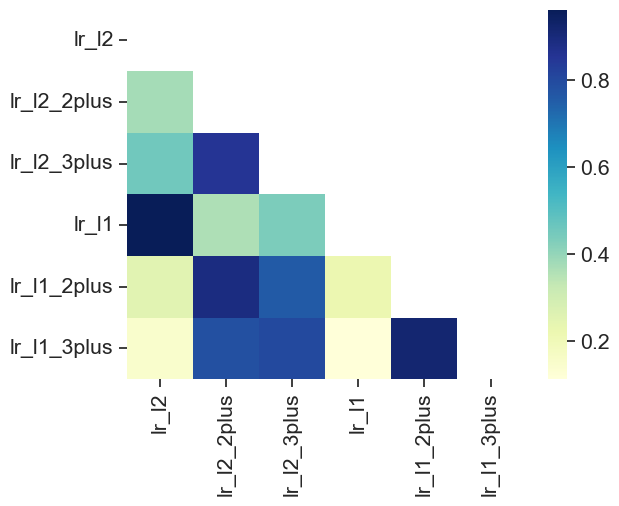

In [394]:
corr_models = df_pred[model_names].corr()
mask = np.triu(np.ones_like(corr_models, dtype=bool))
sns.heatmap(corr_models, cmap="YlGnBu", mask=mask)

plt.show()

In [395]:
df_detected_pred = df_pred[df_pred["Uniprot"].isin(df_detected["Uniprot"])]
print("Number of proteins in brain detected set:", len(df_detected_pred))
df_elevated_pred = df_detected_pred[df_detected_pred["Uniprot"].isin(df_elevated["Uniprot"])]
print("Number of proteins in brain elevated set:", len(df_elevated_pred))
df_val_pred = df_detected_pred[df_detected_pred["Uniprot"].isin(df_val["Uniprot"])]
print("Number of proteins in brain detected validation set:", len(df_val_pred))

Number of proteins in brain detected set: 14662
Number of proteins in brain elevated set: 2079
Number of proteins in brain detected validation set: 12583


In [396]:
# create datasets without ambiguous proteins
df_val_pred_2plus = increase_stringency_CSF(df_val_pred, csf, 2)
df_elevated_pred_2plus = increase_stringency_CSF(df_elevated_pred, csf, 2)

df_val_pred_3plus = increase_stringency_CSF(df_val_pred, csf, 3)
df_elevated_pred_3plus = increase_stringency_CSF(df_elevated_pred, csf, 3)

Number of CSF proteins to be removed: 1368
Number of CSF proteins left: 2311
Number of CSF proteins to be removed: 243
Number of CSF proteins left: 649
Number of CSF proteins to be removed: 1934
Number of CSF proteins left: 1745
Number of CSF proteins to be removed: 367
Number of CSF proteins left: 525


In [397]:
# create subsets of datasets based on CSF class annotation
df_elevated_CSF = df_elevated_pred[df_elevated_pred["CSF"] == 1]
df_elevated_non_CSF = df_elevated_pred[df_elevated_pred["CSF"] == -1]

df_detected_CSF = df_detected_pred[df_detected_pred["CSF"] == 1]
df_detected_non_CSF = df_detected_pred[df_detected_pred["CSF"] == -1]

df_val_CSF = df_val_pred[df_val_pred["CSF"] == 1]
df_val_non_CSF = df_val_pred[df_val_pred["CSF"] == -1]
df_val_CSF_2plus = df_val_pred_2plus[df_val_pred_2plus["CSF"] == 1]
df_val_non_CSF_2plus = df_val_pred_2plus[df_val_pred_2plus["CSF"] == -1]
df_val_CSF_3plus = df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]
df_val_non_CSF_3plus = df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]

# Examine prediction results

## Check distribution of probabilities across CSF classes

### L1 regularization

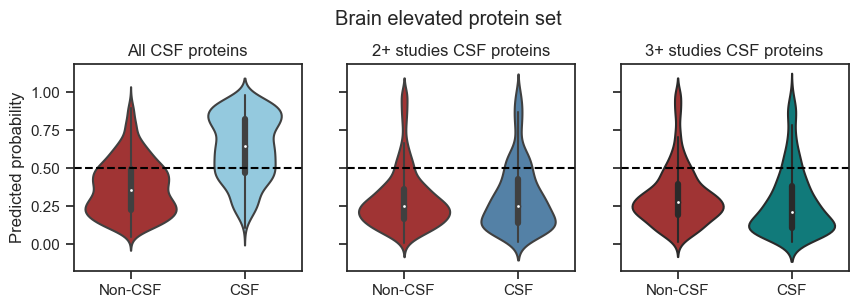

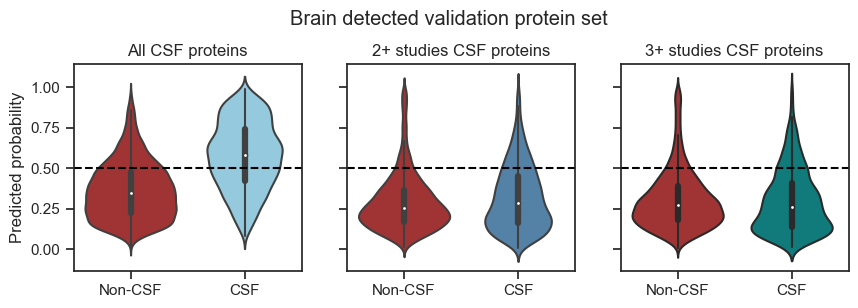

In [398]:
# brain elevated
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)
fig.suptitle("Brain elevated protein set")

sns.violinplot(x="CSF", y="lr_l1", data=df_elevated_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All CSF proteins")
sns.violinplot(x="CSF", y="lr_l1_2plus", data=df_elevated_pred_2plus, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="2+ studies CSF proteins")
sns.violinplot(x="CSF", y="lr_l1_3plus", data=df_elevated_pred_3plus, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="3+ studies CSF proteins")

for i in range(3):
    ax[i].set_xticklabels(["Non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

fig.savefig(fig_path + "Probability_scores_brain_elevated_L1.png", bbox_inches="tight")

# brain detected (not in training data)
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)
fig.suptitle("Brain detected validation protein set")

sns.violinplot(x="CSF", y="lr_l1", data=df_val_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All CSF proteins")
sns.violinplot(x="CSF", y="lr_l1_2plus", data=df_val_pred_2plus, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="2+ studies CSF proteins")
sns.violinplot(x="CSF", y="lr_l1_3plus", data=df_val_pred_3plus, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="3+ studies CSF proteins")

for i in range(3):
    ax[i].set_xticklabels(["Non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_brain_val_L1.png", bbox_inches="tight")

### L2 regularization

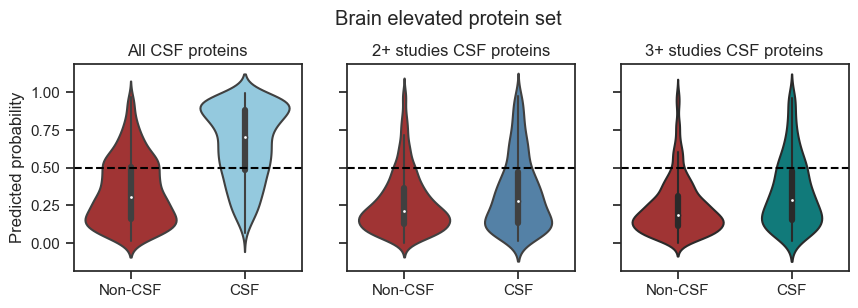

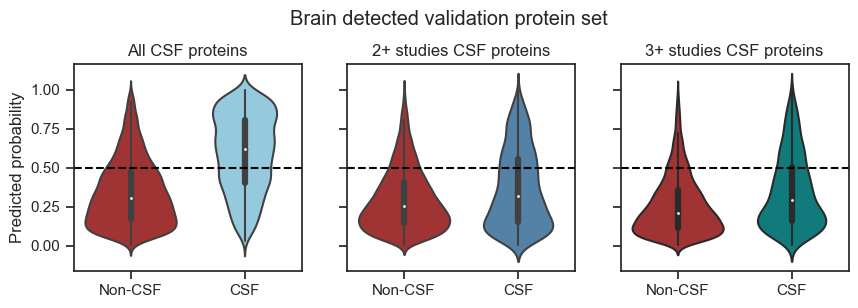

In [399]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.suptitle("Brain elevated protein set")
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)

sns.violinplot(x="CSF", y="lr_l2", data=df_elevated_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All CSF proteins")
sns.violinplot(x="CSF", y="lr_l2_2plus", data=df_elevated_pred_2plus, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="2+ studies CSF proteins")
sns.violinplot(x="CSF", y="lr_l2_3plus", data=df_elevated_pred_3plus, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="3+ studies CSF proteins")

for i in range(3):
    ax[i].set_xticklabels(["Non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

fig.savefig(fig_path + "Probability_scores_brain_elevated_L2.png", bbox_inches="tight")

# brain detected (not in training data)
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)
fig.suptitle("Brain detected validation protein set")

sns.violinplot(x="CSF", y="lr_l2", data=df_val_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All CSF proteins")
ax[0].set_xticklabels(["Non-CSF", "CSF"])
sns.violinplot(x="CSF", y="lr_l2_2plus", data=df_val_pred_2plus, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="2+ studies CSF proteins")
ax[1].set_xticklabels(["Non-CSF", "CSF"])
sns.violinplot(x="CSF", y="lr_l2_3plus", data=df_val_pred_3plus, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="3+ studies CSF proteins")
ax[2].set_xticklabels(["Non-CSF", "CSF"])

for i in range(3):
    ax[i].set_xticklabels(["Non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_brain_val_L2.png", bbox_inches="tight")

In [400]:
# print(df_val_pred.groupby("CSF").median()["lr_l2"])
# print(df_val_pred_2plus.groupby("CSF").median()["lr_l2_2plus"])
# print(df_val_pred_3plus.groupby("CSF").median()["lr_l2_3plus"])

# print(df_val_pred.groupby("CSF").median()["lr_l1"])
# print(df_val_pred_2plus.groupby("CSF").median()["lr_l1_2plus"])
# print(df_val_pred_3plus.groupby("CSF").median()["lr_l1_3plus"])

In [401]:
print((df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]["lr_l2"] > 0.5).sum()/len(df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]))
print((df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]["lr_l2"] < 0.5).sum()/len(df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]))

print((df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]["lr_l2_2plus"] > 0.5).sum()/len(df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]))
print((df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]["lr_l2_2plus"] < 0.5).sum()/len(df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]))

print((df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]["lr_l2_3plus"] > 0.5).sum()/len(df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]))
print((df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]["lr_l2_3plus"] < 0.5).sum()/len(df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]))

0.8120343839541547
0.7844788858939802
0.29054441260744984
0.8429919137466307
0.25272206303724926
0.8840970350404312


In [402]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, precision_score, recall_score, classification_report

y_true = df_val_pred["CSF"]
y_pred_1 = np.where(df_val_pred["lr_l2"] > 0.5, 1, -1)
y_pred_2 = np.where(df_val_pred["lr_l2_2plus"] > 0.5, 1, -1)
y_pred_3 = np.where(df_val_pred["lr_l2_3plus"] > 0.5, 1, -1)

print(classification_report(y_true, y_pred_1))
print(classification_report(y_true, y_pred_2))
print(classification_report(y_true, y_pred_3))

              precision    recall  f1-score   support

          -1       0.84      0.78      0.81      8904
           1       0.55      0.64      0.59      3679

    accuracy                           0.74     12583
   macro avg       0.69      0.71      0.70     12583
weighted avg       0.75      0.74      0.75     12583

              precision    recall  f1-score   support

          -1       0.74      0.84      0.79      8904
           1       0.43      0.29      0.35      3679

    accuracy                           0.68     12583
   macro avg       0.59      0.57      0.57     12583
weighted avg       0.65      0.68      0.66     12583

              precision    recall  f1-score   support

          -1       0.73      0.88      0.80      8904
           1       0.45      0.23      0.30      3679

    accuracy                           0.69     12583
   macro avg       0.59      0.56      0.55     12583
weighted avg       0.65      0.69      0.66     12583



In [403]:
print((df_val_pred[df_val_pred["CSF"] == 1]["lr_l2"] > 0.5).sum()/len(df_val_pred[df_val_pred["CSF"] == 1]))
print((df_val_pred[df_val_pred["CSF"] == -1]["lr_l2"] < 0.5).sum()/len(df_val_pred[df_val_pred["CSF"] == -1]))

print((df_val_pred_2plus[df_val_pred_2plus["CSF"] == 1]["lr_l2_2plus"] > 0.5).sum()/len(df_val_pred_2plus[df_val_pred_2plus["CSF"] == 1]))
print((df_val_pred_2plus[df_val_pred_2plus["CSF"] == -1]["lr_l2_2plus"] < 0.5).sum()/len(df_val_pred_2plus[df_val_pred_2plus["CSF"] == -1]))

print((df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]["lr_l2_3plus"] > 0.5).sum()/len(df_val_pred_3plus[df_val_pred_3plus["CSF"] == 1]))
print((df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]["lr_l2_3plus"] < 0.5).sum()/len(df_val_pred_3plus[df_val_pred_3plus["CSF"] == -1]))

0.6357705898341941
0.7844788858939802
0.30549545651233234
0.8429919137466307
0.25272206303724926
0.8840970350404312


## Prediction confidence across number of studies proteins were found in

In [404]:
studies_proba_val = csf[["Uniprot", "#Studies"]].merge(df_val_CSF[["Uniprot", "lr_l2", "lr_l2_2plus", 
    "lr_l2_3plus"]], on="Uniprot", how="inner")
studies_proba_elevated = csf[["Uniprot", "#Studies"]].merge(df_elevated_CSF[["Uniprot", "lr_l2", "lr_l2_2plus", 
    "lr_l2_3plus"]], on="Uniprot", how="inner")

In [405]:
studies_proba_val

,Uniprot,#Studies,lr_l2,lr_l2_2plus,lr_l2_3plus
0,Q6K0P9,1,0.262869,0.305382,0.382857
1,P09529,5,0.806386,0.154186,0.158740
2,P61019,3,0.827551,0.560139,0.454124
3,Q9GZX9,6,0.524174,0.027830,0.018445
4,Q96RP7,4,0.546853,0.081752,0.089537
...,...,...,...,...,...
3674,O14647,1,0.210949,0.399528,0.329989
3675,O75064,1,0.234640,0.147888,0.088447
3676,P16471,1,0.901633,0.200228,0.387433
3677,Q5T1M5,1,0.776368,0.558331,0.572774


In [406]:
#### TO DO ####
# multiple testing correction
    
p_elevated = []
print("Brain elevated protein set")
for i in range(5):
    _, p = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == i+1]["lr_l2"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == i+2]["lr_l2"])
    print("Comparison of %i and %i: %s" % (i+1, i+2, print_p_val(p)))
    p_elevated.append(p)

p_vals_val = []
print("Brain detected validation protein set")
for i in range(5):
    _, p = mannwhitneyu(studies_proba_val[studies_proba_val["#Studies"] == i+1]["lr_l2"], 
                        studies_proba_val[studies_proba_val["#Studies"] == i+2]["lr_l2"])
    print("Comparison of %i and %i: %s" % (i+1, i+2, print_p_val(p)))
    p_vals_val.append(p)


Brain elevated protein set
Comparison of 1 and 2: 0.0001
Comparison of 2 and 3: 0.0999
Comparison of 3 and 4: 0.0082
Comparison of 4 and 5: 0.2140
Comparison of 5 and 6: 0.0276
Brain detected validation protein set
Comparison of 1 and 2: < 0.0001
Comparison of 2 and 3: 0.0013
Comparison of 3 and 4: 0.0114
Comparison of 4 and 5: 0.0053
Comparison of 5 and 6: < 0.0001


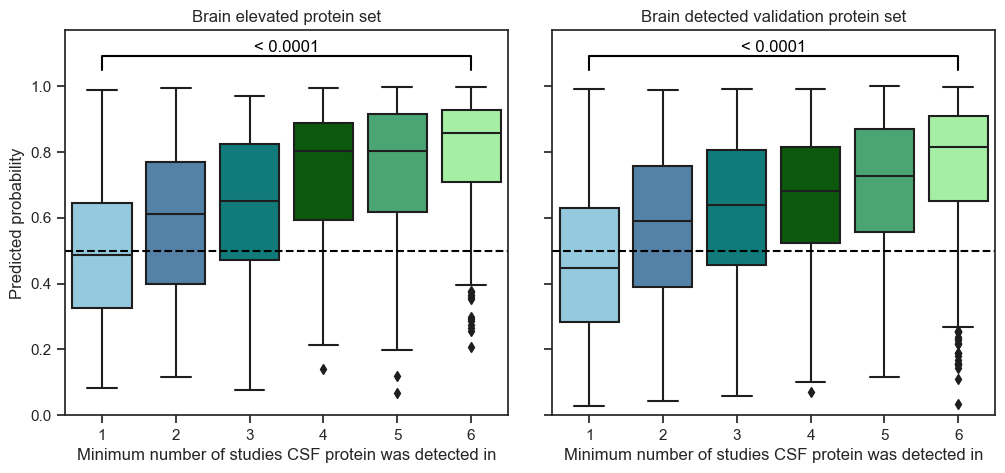

In [407]:
# calculate p-values
_, p_val = mannwhitneyu(studies_proba_val[studies_proba_val["#Studies"] == 1]["lr_l2"], 
                        studies_proba_val[studies_proba_val["#Studies"] == 6]["lr_l2"])
_, p_elevated = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == 1]["lr_l2"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == 6]["lr_l2"])

sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.subplots_adjust(wspace=0.1)
plt.setp(ax, ylim=(0, 1.17))

palette=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"]

sns.boxplot(x="#Studies", y="lr_l2", data=studies_proba_elevated, palette=palette, ax=ax[0])
ax[0].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel="Predicted probability",
      title="Brain elevated protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[0].plot([0, 0, 5, 5], [r, r+h, r+h, r], lw=1.5, color="black")
ax[0].text(2.5, r+0.045, print_p_val(p_elevated), ha="center", va="bottom", color="black")

sns.boxplot(x="#Studies", y="lr_l2", data=studies_proba_val, palette=palette, ax=ax[1])
ax[1].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel=None,
      title="Brain detected validation protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[1].plot([0, 0, 5, 5], [r, r+h, r+h, r], lw=1.5, color="black")
ax[1].text(2.5, r+0.045, print_p_val(p_val), ha="center", va="bottom", color="black")

for i in range(2):
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_vs_study_number.png", bbox_inches="tight")

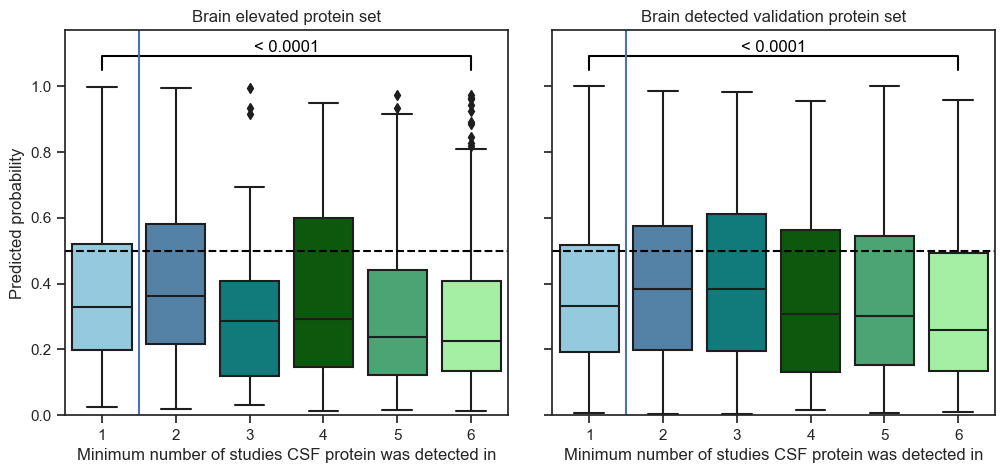

In [408]:
# calculate p-values
_, p_val = mannwhitneyu(studies_proba_val[studies_proba_val["#Studies"] == 1]["lr_l2_2plus"], 
                        studies_proba_val[studies_proba_val["#Studies"] == 6]["lr_l2_2plus"])
_, p_elevated = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == 1]["lr_l2_2plus"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == 6]["lr_l2_2plus"])

sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.subplots_adjust(wspace=0.1)
plt.setp(ax, ylim=(0, 1.17))

sns.boxplot(x="#Studies", y="lr_l2_2plus", data=studies_proba_elevated, palette=palette, ax=ax[0])
ax[0].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel="Predicted probability",
      title="Brain elevated protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[0].plot([0, 0, 5, 5], [r, r+h, r+h, r], lw=1.5, color="black")
ax[0].text(2.5, r+0.045, print_p_val(p_elevated), ha="center", va="bottom", color="black")

sns.boxplot(x="#Studies", y="lr_l2_2plus", data=studies_proba_val, palette=palette, ax=ax[1])
ax[1].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel=None,
      title="Brain detected validation protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[1].plot([0, 0, 5, 5], [r, r+h, r+h, r], lw=1.5, color="black")
ax[1].text(2.5, r+0.045, print_p_val(p_val), ha="center", va="bottom", color="black")

for i in range(2):
    ax[i].axhline(0.5, color="black", linestyle="--")
    ax[i].axvline(0.5)
    
plt.show()
fig.savefig(fig_path + "Probability_scores_vs_study_number_2plus.png", bbox_inches="tight")

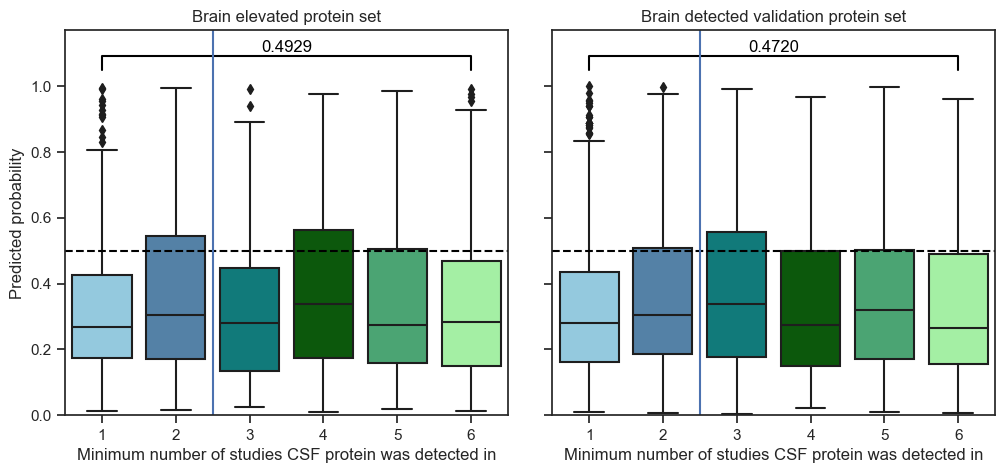

In [409]:
# calculate p-values
_, p_val = mannwhitneyu(studies_proba_val[studies_proba_val["#Studies"] == 1]["lr_l2_3plus"], 
                        studies_proba_val[studies_proba_val["#Studies"] == 6]["lr_l2_3plus"])
_, p_elevated = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == 1]["lr_l2_3plus"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == 6]["lr_l2_3plus"])

sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.subplots_adjust(wspace=0.1)
plt.setp(ax, ylim=(0, 1.17))

sns.boxplot(x="#Studies", y="lr_l2_3plus", data=studies_proba_elevated, palette=palette, ax=ax[0])
ax[0].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel="Predicted probability",
      title="Brain elevated protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[0].plot([0, 0, 5, 5], [r, r+h, r+h, r], lw=1.5, color="black")
ax[0].text(2.5, r+0.045, print_p_val(p_elevated), ha="center", va="bottom", color="black")

sns.boxplot(x="#Studies", y="lr_l2_3plus", data=studies_proba_val, palette=palette, ax=ax[1])
ax[1].set(xlabel="Minimum number of studies CSF protein was detected in", ylabel=None,
      title="Brain detected validation protein set")
# add p-value annotations
r, h = 1.05, 0.04
ax[1].plot([0, 0, 5, 5], [r, r+h, r+h, r], lw=1.5, color="black")
ax[1].text(2.5, r+0.045, print_p_val(p_val), ha="center", va="bottom", color="black")

for i in range(2):
    ax[i].axhline(0.5, color="black", linestyle="--")
    ax[i].axvline(1.5)

plt.show()
fig.savefig(fig_path + "Probability_scores_vs_study_number_3plus.png", bbox_inches="tight")

### Combine negative and per study predicted probabilities

In [410]:
studies_proba_val_all = df_val_pred[["Uniprot", "lr_l2", "lr_l2_2plus", "lr_l2_3plus"]].merge(csf[["Uniprot", "#Studies"]], 
    on="Uniprot", how="left")
studies_proba_val_all.value_counts("#Studies", dropna=False)
studies_proba_val_all["#Studies"].fillna(0, inplace=True)

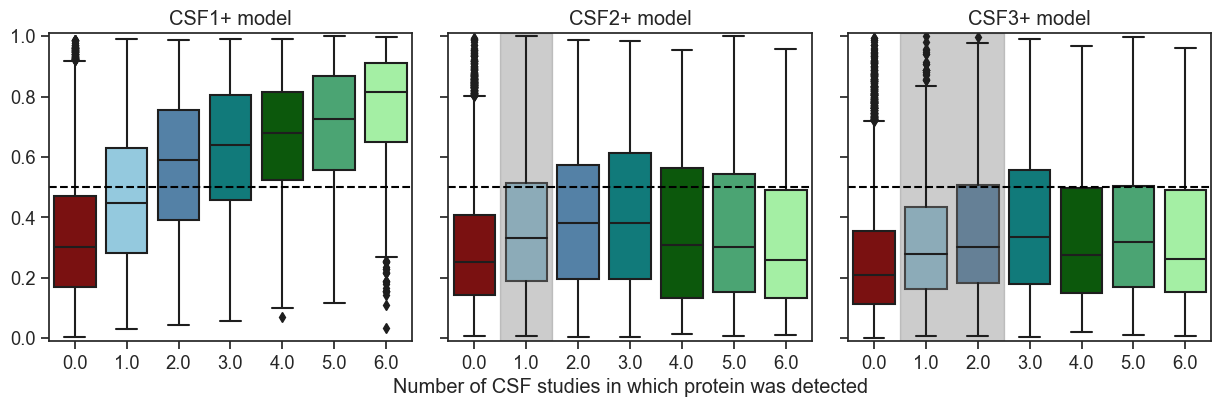

In [411]:
# calculate p-values
_, p = mannwhitneyu(studies_proba_val[studies_proba_val["#Studies"] == 1]["lr_l2"], 
                        studies_proba_val[studies_proba_val["#Studies"] == 6]["lr_l2"])
_, p_2plus = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == 1]["lr_l2_2plus"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == 6]["lr_l2_2plus"])
_, p_3plus = mannwhitneyu(studies_proba_elevated[studies_proba_elevated["#Studies"] == 1]["lr_l2_3plus"], 
                        studies_proba_elevated[studies_proba_elevated["#Studies"] == 6]["lr_l2_3plus"])

sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 3, figsize=(15,4), sharey=True)
fig.subplots_adjust(wspace=0.1)
plt.setp(ax, ylim=(-0.01, 1.01))

palette=["darkred", "skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"]

sns.boxplot(x="#Studies", y="lr_l2", data=studies_proba_val_all, palette=palette, ax=ax[0])
ax[0].set(xlabel=None, ylabel=None, title="CSF1+ model")

sns.boxplot(x="#Studies", y="lr_l2_2plus", data=studies_proba_val_all, palette=palette, ax=ax[1])
ax[1].set(xlabel="Number of CSF studies in which protein was detected", ylabel=None, title="CSF2+ model")
ax[1].axvspan(0.5, 1.5, color="grey", alpha=0.4)

sns.boxplot(x="#Studies", y="lr_l2_3plus", data=studies_proba_val_all, palette=palette, ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="CSF3+ model")
ax[2].axvspan(0.5, 2.5, color="grey", alpha=0.4)

for i in range(3):
    ax[i].axhline(0.5, color="black", linestyle="--")
    
plt.show()
fig.savefig(fig_path + "Probability_scores_vs_study_number_nonCSF_CSF.png", bbox_inches="tight", dpi=300, transparent=True)

## Compare difference in brain expression levels between annotations and predictions

In [412]:
brain_exp = brain_elevated[["Uniprot", "Brain expression"]]
brain_exp["log2(Brain expression)"] = np.log2(brain_exp["Brain expression"])
brain_exp_CSF = brain_exp.merge(df_detected_pred[["Uniprot", "CSF", "lr_l2", "lr_l2_2plus", "lr_l2_3plus"]], 
    on="Uniprot", how="inner")
brain_exp_CSF["binary_lr_l2"] = np.where(brain_exp_CSF["lr_l2"] > 0.5, 1, -1)
brain_exp_CSF["binary_lr_l2_2plus"] = np.where(brain_exp_CSF["lr_l2_2plus"] > 0.5, 1, -1)
brain_exp_CSF["binary_lr_l2_3plus"] = np.where(brain_exp_CSF["lr_l2_3plus"] > 0.5, 1, -1)
brain_exp_CSF

,Uniprot,Brain expression,log2(Brain expression),CSF,lr_l2,lr_l2_2plus,lr_l2_3plus,binary_lr_l2,binary_lr_l2_2plus,binary_lr_l2_3plus
0,P51861,38856.0,15.245850,-1,0.037379,0.045706,0.046669,-1,-1,-1
1,Q96PE5,149.9,7.227857,1,0.473441,0.055475,0.072545,-1,-1,-1
2,Q8IWU9,117.3,6.874059,-1,0.480274,0.313552,0.218235,-1,-1,-1
3,A6NKF7,416.1,8.700786,-1,0.103083,0.043007,0.018615,-1,-1,-1
4,P02686,32454.4,14.986126,1,0.275773,0.206966,0.349113,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
2074,Q7Z570,5.2,2.378512,-1,0.072260,0.227246,0.258993,-1,-1,-1
2075,A4D1E1,2.2,1.137504,-1,0.137141,0.111594,0.104011,-1,-1,-1
2076,Q05481,30.4,4.925999,-1,0.152691,0.163645,0.059421,-1,-1,-1
2077,Q96LW9,43.6,5.446256,-1,0.108181,0.159539,0.103016,-1,-1,-1


In [413]:
# annotations
CSF_annot = brain_exp_CSF[brain_exp_CSF["CSF"] == 1]
non_CSF_annot = brain_exp_CSF[brain_exp_CSF["CSF"] == -1]
_, p_annot = mannwhitneyu(CSF_annot["Brain expression"], non_CSF_annot["Brain expression"])
print("P-value for annotations:", p_annot)

# predictions
CSF_pred = brain_exp_CSF[brain_exp_CSF["binary_lr_l2"] == 1]
non_CSF_pred = brain_exp_CSF[brain_exp_CSF["binary_lr_l2"] == -1]
_, p_pred = mannwhitneyu(CSF_pred["Brain expression"], non_CSF_pred["Brain expression"])
print("P-value for predictions :", p_pred)

CSF_pred_2plus = brain_exp_CSF[brain_exp_CSF["binary_lr_l2_2plus"] == 1]
non_CSF_pred_2plus = brain_exp_CSF[brain_exp_CSF["binary_lr_l2_2plus"] == -1]
_, p_pred_2plus = mannwhitneyu(CSF_pred_2plus["Brain expression"], non_CSF_pred_2plus["Brain expression"])
print("P-value for predictions (CSF2+):", p_pred_2plus)

CSF_pred_3plus = brain_exp_CSF[brain_exp_CSF["binary_lr_l2_3plus"] == 1]
non_CSF_pred_3plus = brain_exp_CSF[brain_exp_CSF["binary_lr_l2_3plus"] == -1]
_, p_pred_3plus = mannwhitneyu(CSF_pred_3plus["Brain expression"], non_CSF_pred_3plus["Brain expression"])
print("P-value for predictions (CSF3+):", p_pred_3plus)

P-value for annotations: 7.3035244111497575e-25
P-value for predictions : 4.723996175624725e-05
P-value for predictions (CSF2+): 1.223876426479348e-09
P-value for predictions (CSF3+): 8.74465912260764e-08


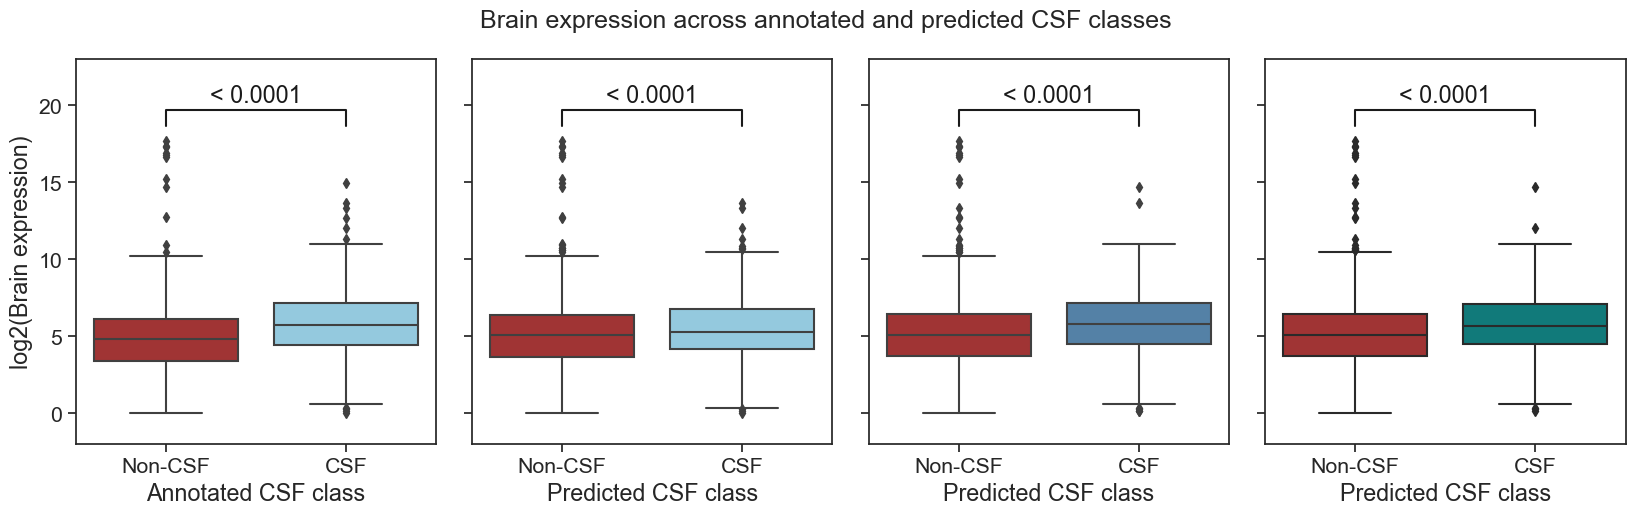

In [414]:
sns.set(style=("ticks"), font_scale=1.4)
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True)
fig.subplots_adjust(wspace=0.1)
fig.suptitle("Brain expression across annotated and predicted CSF classes", fontsize=18)

palette=["firebrick", "skyblue"]

sns.boxplot(x="CSF", y="log2(Brain expression)", data=brain_exp_CSF, palette=palette, ax=ax[0])
ax[0].set(xlabel="Annotated CSF class")
y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
ax[0].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c="k")
ax[0].text(.5, y+1.2, print_p_val(p_annot), ha="center", va="bottom", color="k")
ax[0].set_xticklabels(["Non-CSF", "CSF"])

sns.boxplot(x="binary_lr_l2", y="log2(Brain expression)", data=brain_exp_CSF, palette=palette, ax=ax[1])
ax[1].set(xlabel="Predicted CSF class", ylabel=None, ylim=(-2, 23))
y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
ax[1].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, color="k")
ax[1].text(0.5, y+1.2, print_p_val(p_pred), ha="center", va="bottom", color="k")
ax[1].set_xticklabels(["Non-CSF", "CSF"])

sns.boxplot(x="binary_lr_l2_2plus", y="log2(Brain expression)", data=brain_exp_CSF, palette=["firebrick", "steelblue"],
    ax=ax[2])
ax[2].set(xlabel="Predicted CSF class", ylabel=None, ylim=(-2, 23))
y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
ax[2].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, color="k")
ax[2].text(0.5, y+1.2, print_p_val(p_pred_2plus), ha="center", va="bottom", color="k")
ax[2].set_xticklabels(["Non-CSF", "CSF"])

sns.boxplot(x="binary_lr_l2_3plus", y="log2(Brain expression)", data=brain_exp_CSF, palette=["firebrick", "darkcyan"],
    ax=ax[3])
ax[3].set(xlabel="Predicted CSF class", ylabel=None, ylim=(-2, 23))
y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
ax[3].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, color="k")
ax[3].text(0.5, y+1.2, print_p_val(p_pred_3plus), ha="center", va="bottom", color="k")
ax[3].set_xticklabels(["Non-CSF", "CSF"])

plt.show()
fig.savefig(fig_path + "Bar_brain_expression_vs_CSF_class_pred_annot.png", bbox_inches="tight")

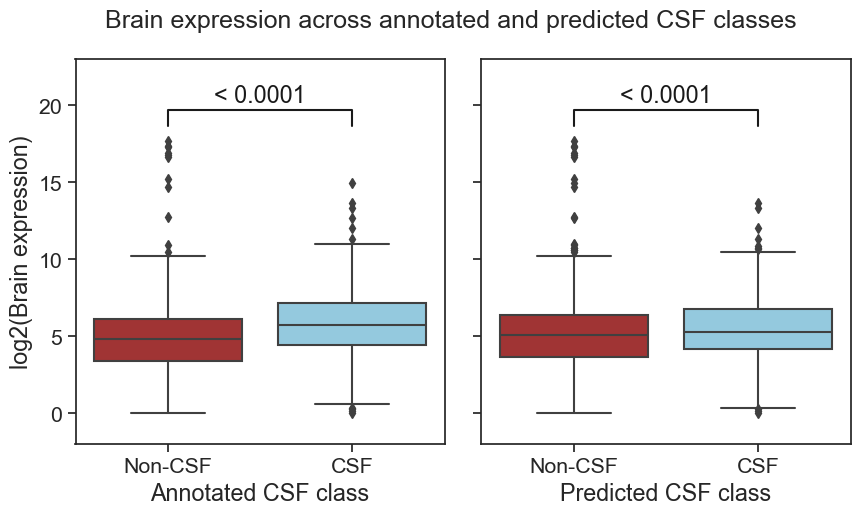

In [415]:
sns.set(style=("ticks"), font_scale=1.4)
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.1)
fig.suptitle("Brain expression across annotated and predicted CSF classes", fontsize=18)

palette=["firebrick", "skyblue"]

sns.boxplot(x="CSF", y="log2(Brain expression)", data=brain_exp_CSF, palette=palette, ax=ax[0])
ax[0].set(xlabel="Annotated CSF class")
y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
ax[0].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c="k")
ax[0].text(.5, y+1.2, print_p_val(p_annot), ha="center", va="bottom", color="k")
ax[0].set_xticklabels(["Non-CSF", "CSF"])

sns.boxplot(x="binary_lr_l2", y="log2(Brain expression)", data=brain_exp_CSF, palette=palette, ax=ax[1])
ax[1].set(xlabel="Predicted CSF class", ylabel=None, ylim=(-2, 23))
y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
ax[1].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, color="k")
ax[1].text(0.5, y+1.2, print_p_val(p_pred), ha="center", va="bottom", color="k")
ax[1].set_xticklabels(["Non-CSF", "CSF"])

# sns.boxplot(x="binary_lr_l2_2plus", y="log2(Brain expression)", data=brain_exp_CSF, palette=["firebrick", "steelblue"],
#     ax=ax[2])
# ax[2].set(xlabel="Predicted CSF class", ylabel=None, ylim=(-2, 23))
# y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
# ax[2].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, color="k")
# ax[2].text(0.5, y+1.2, print_p_val(p_pred_2plus), ha="center", va="bottom", color="k")
# ax[2].set_xticklabels(["Non-CSF", "CSF"])

# sns.boxplot(x="binary_lr_l2_3plus", y="log2(Brain expression)", data=brain_exp_CSF, palette=["firebrick", "darkcyan"],
#     ax=ax[3])
# ax[3].set(xlabel="Predicted CSF class", ylabel=None, ylim=(-2, 23))
# y, h = max(brain_exp_CSF["log2(Brain expression)"]) + 1, 1
# ax[3].plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, color="k")
# ax[3].text(0.5, y+1.2, print_p_val(p_pred_3plus), ha="center", va="bottom", color="k")
# ax[3].set_xticklabels(["Non-CSF", "CSF"])

plt.show()
# fig.savefig(fig_path + "Bar_brain_expression_vs_CSF_class_pred_annot.png", bbox_inches="tight")

In [416]:
TN = brain_exp_CSF[(brain_exp_CSF["CSF"] == -1) & (brain_exp_CSF["binary_lr_l2_2plus"] == -1)]
FP = brain_exp_CSF[(brain_exp_CSF["CSF"] == -1) & (brain_exp_CSF["binary_lr_l2_2plus"] == 1)]
TP = brain_exp_CSF[(brain_exp_CSF["CSF"] == 1) & (brain_exp_CSF["binary_lr_l2_2plus"] == 1)]
FN = brain_exp_CSF[(brain_exp_CSF["CSF"] == 1) & (brain_exp_CSF["binary_lr_l2_2plus"] == -1)]

P = brain_exp_CSF[(brain_exp_CSF["CSF"] == 1)]
N = brain_exp_CSF[(brain_exp_CSF["CSF"] == -1)]
PP = brain_exp_CSF[(brain_exp_CSF["binary_lr_l2_2plus"] == 1)]
PN = brain_exp_CSF[(brain_exp_CSF["binary_lr_l2_2plus"] == -1)]

l = [TN, N, FP, TP, P, FN, PP, PN]

In [417]:
print("Brain expression positives:", np.median(P["log2(Brain expression)"]))
print("Brain expression negatives:", np.median(N["log2(Brain expression)"]))
print("Brain expression predicted positives:", np.median(PP["log2(Brain expression)"]))
print("Brain expression predicted negatives:", np.median(PN["log2(Brain expression)"]))

Brain expression positives: 5.730637397588513
Brain expression negatives: 4.842978831788326
Brain expression predicted positives: 5.776103988073165
Brain expression predicted negatives: 5.1001366712854495


In [418]:
# sns.set(style=("ticks"), font_scale=1)
# fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# sns.boxplot(y="log2(Brain expression)", x="CSF", hue="binary_lr_l2_2plus", data=brain_exp_CSF, 
#     palette=["firebrick", "skyblue"])
# ax.legend(title="CSF annotation", loc="upper right")
# ax.set(xlabel="CSF prediction", ylabel="log2(Brain expression)", 
#     title="Protein expression across CSF \n annotation and prediction classes", ylim=(-1,27))

# y, h = max(TN["log2(Brain expression)"]) + 1, 1
# ax.plot([-0.2, -0.2, 0.2, 0.2], [y, y+h, y+h, y], lw=1.5, color="k")
# ax.text(0, y+1.2, "", ha="center", va="bottom", color="k")
# y, h = max(FN["log2(Brain expression)"]) + 1, 1
# ax.plot([0.8, 0.8, 1.2, 1.2], [y, y+h, y+h, y], lw=1.5, color="k")
# ax.text(1, y+1.2, "", ha="center", va="bottom", color="k")

# plt.show()

# Biomarkers

## Overlap of biomarker ranking with known disease markers

### Dementia  (BIONDA)

In [419]:
df_detected_pred

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PS00028,PS00022,PS01186,CSF,lr_l2,lr_l2_2plus,lr_l2_3plus,lr_l1,lr_l1_2plus,lr_l1_3plus
1,P15502,MAGLTAAAPRPGVLLLLLSILHPSRPGGVPGAIPGGVPGGVFYPGA...,786,68396.5989,0.212468,0.002545,0.003817,0.006361,0.020356,0.286260,...,0,0,0,1,0.999805,0.999405,0.998764,0.982049,0.999382,0.998586
2,Q8TDW7,MDIIMGHCVGTRPPACCLILLLFKLLATVSQGLPGTGPLGFHFTHS...,4557,501972.1349,0.054641,0.013386,0.074172,0.060347,0.041914,0.064077,...,0,1,1,1,0.998578,0.734875,0.570439,0.982608,0.581590,0.178573
4,Q9NYQ8,MTIALLGFAIFLLHCATCEKPLEGILSSSAWHFTHSHYNATIYENS...,4349,479311.4528,0.061853,0.012417,0.063693,0.061623,0.038400,0.065532,...,0,1,1,1,0.997582,0.676151,0.468425,0.974411,0.444930,0.106325
5,P08572,MGRDQRAVAGPALRRWLLLGTVTVGFLAQSVLAGVKKFDVPCGGRD...,1712,167551.0988,0.047897,0.012266,0.047897,0.035047,0.033294,0.276285,...,0,0,0,1,0.997005,0.883198,0.702364,0.985883,0.806336,0.501774
7,P02452,MFSFVDLRLLLLLAATALLTHGQEEGQVEGQDEDIPPITCVQNGLR...,1464,138909.8243,0.095628,0.012295,0.045082,0.051230,0.018443,0.267077,...,0,0,0,1,0.995771,0.924277,0.869068,0.980361,0.881451,0.762293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16743,Q5FWF7,MHKNSKRNNNLRVSHTEANSVDAEKEKNESQNNFFELLPAEITFKI...,155,18240.4281,0.045161,0.032258,0.058065,0.090323,0.025806,0.019355,...,0,0,0,-1,0.011923,0.060946,0.042389,0.044314,0.094107,0.188790
16746,Q96AK3,MNPQIRNPMERMYRDTFYDNFENEPILYGRSYTWLCYEVKIKRGRS...,386,46597.8828,0.046632,0.044041,0.044041,0.064767,0.075130,0.036269,...,0,0,0,-1,0.010792,0.031174,0.024296,0.040783,0.063018,0.096801
16751,P09017,MIMSSYLMDSNYIDPKFPPCEEYSQNSYIPEHSPEYYGRTRESGFQ...,264,29810.8868,0.075758,0.018939,0.022727,0.068182,0.015152,0.045455,...,0,0,0,-1,0.009423,0.053709,0.080796,0.087097,0.096818,0.201572
16753,Q96LW7,MTDQTYCDRLVQDTPFLTGHGRLSEQQVDRIILQLNRYYPQILTNK...,228,25589.1823,0.070175,0.035088,0.030702,0.026316,0.030702,0.048246,...,0,0,0,-1,0.008791,0.013976,0.007040,0.024666,0.029855,0.033331


Number of associated markers: 180
Percent predicted as CSF secreted: 0.6
Percent predicted as non-CSF secreted: 0.4


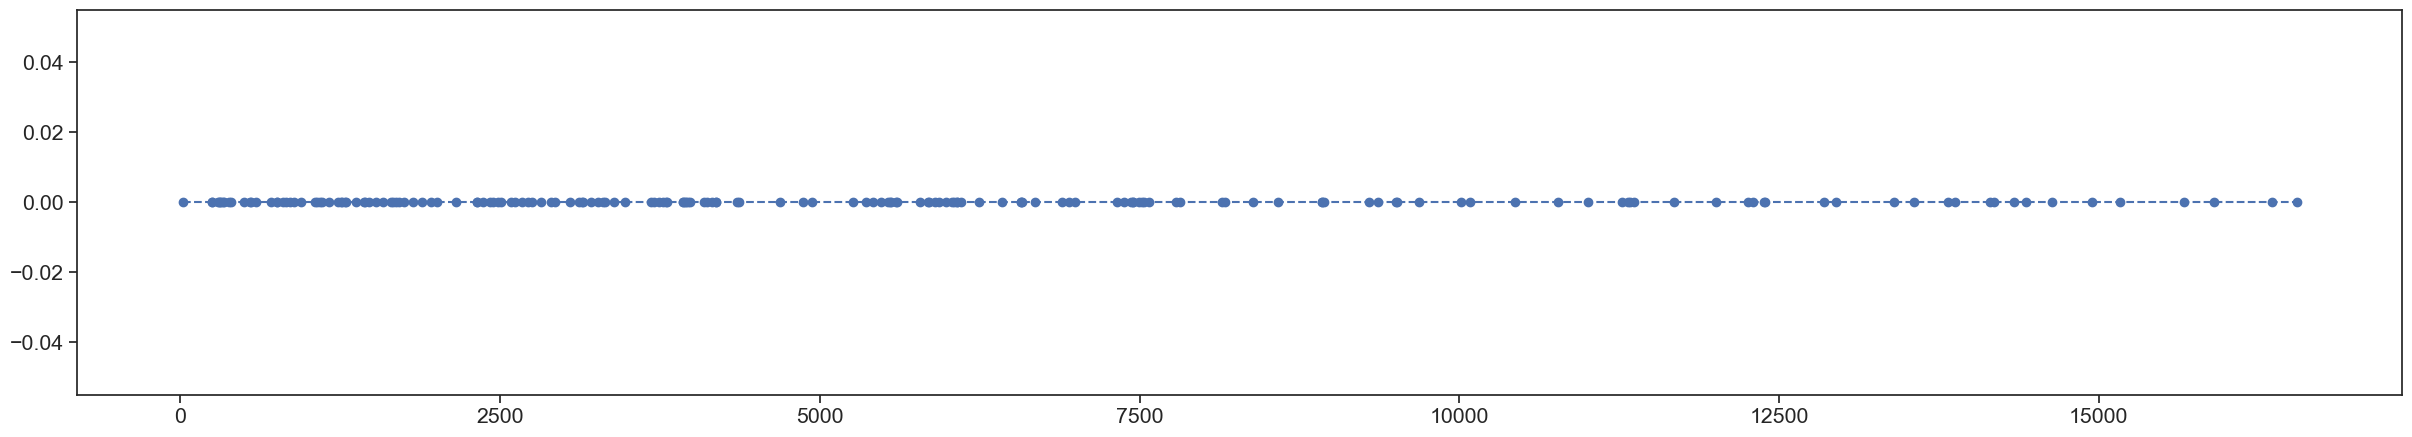

In [420]:
# keep only significant associated markers
dementia_markers_sig = dementia_markers_BIONDA[dementia_markers_BIONDA["Score"] < 0.05]
# keep only markers
df_pred_dementia_markers = df_detected_pred[df_detected_pred["Uniprot"].isin(dementia_markers_sig["MarkerID"])] 
print("Number of associated markers:", len(df_pred_dementia_markers))
print("Percent predicted as CSF secreted:", 
    len(df_pred_dementia_markers[df_pred_dementia_markers["lr_l2"] > 0.5])/len(df_pred_dementia_markers))
print("Percent predicted as non-CSF secreted:", 
    len(df_pred_dementia_markers[df_pred_dementia_markers["lr_l2"] < 0.5])/len(df_pred_dementia_markers))

fig, ax = plt.subplots(1, 1, figsize=(30,5))
plt.plot(df_pred_dementia_markers.index, np.zeros(len(df_pred_dementia_markers.index)), "--bo")
plt.show()

### Neurodegenerative diseases (BIONDA)

Number of associated markers: 87
Percent predicted as CSF secreted: 0.47126436781609193
Percent predicted as non-CSF secreted: 0.5287356321839081


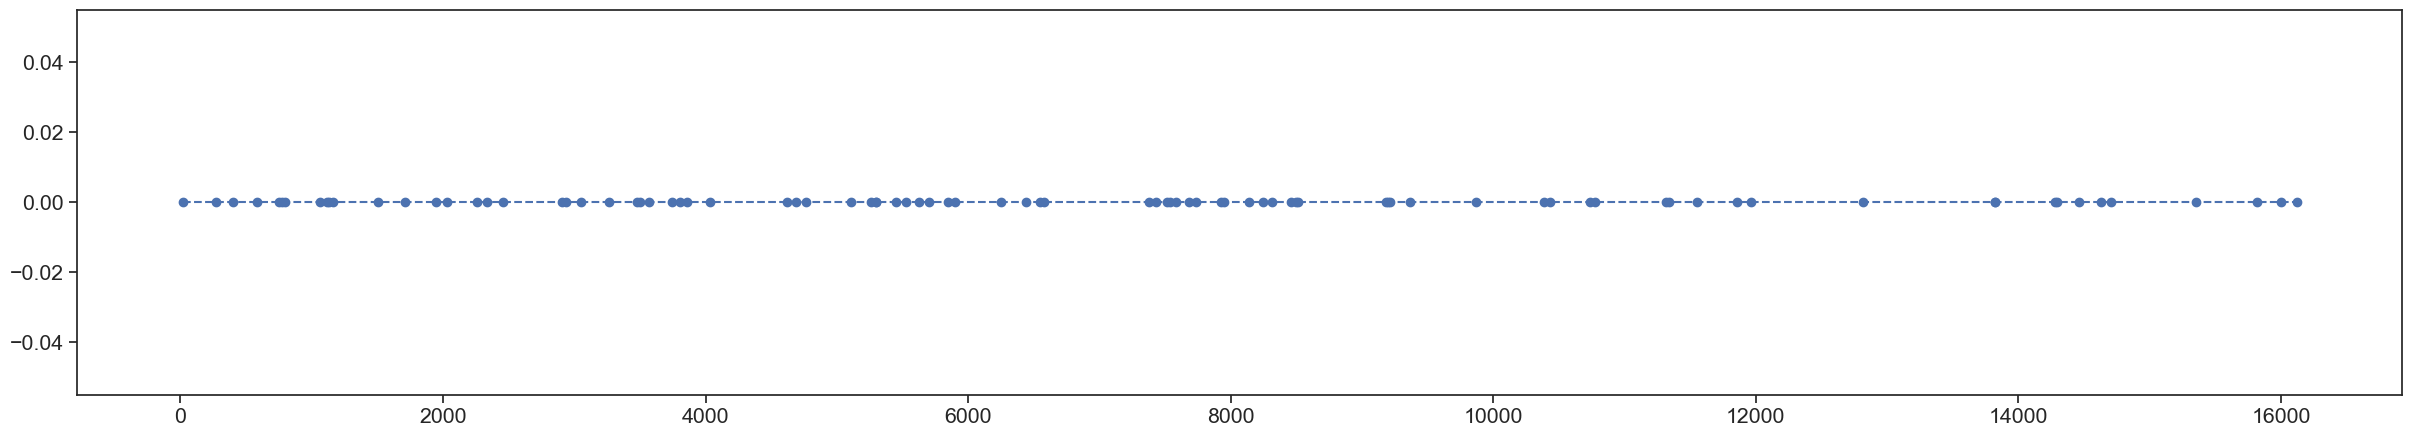

In [421]:
ND_markers_sig = ND_markers[ND_markers["Score"] < 0.05]
df_pred_ND_markers = df_detected_pred[df_detected_pred["Uniprot"].isin(ND_markers_sig["MarkerID"])] 
print("Number of associated markers:", len(df_pred_ND_markers))
print("Percent predicted as CSF secreted:", 
    len(df_pred_ND_markers[df_pred_ND_markers["lr_l2"] > 0.5])/len(df_pred_ND_markers))
print("Percent predicted as non-CSF secreted:", 
    len(df_pred_ND_markers[df_pred_ND_markers["lr_l2"] < 0.5])/len(df_pred_ND_markers))

fig, ax = plt.subplots(1, 1, figsize=(30,5))
plt.plot(df_pred_ND_markers.index, np.zeros(len(df_pred_ND_markers.index)), "--bo")
plt.show()

### Alzheimer's Disease (DisGeNet)

Number of associated markers: 121
Percent predicted as CSF secreted: 0.6446280991735537
Percent predicted as non-CSF secreted: 0.35537190082644626


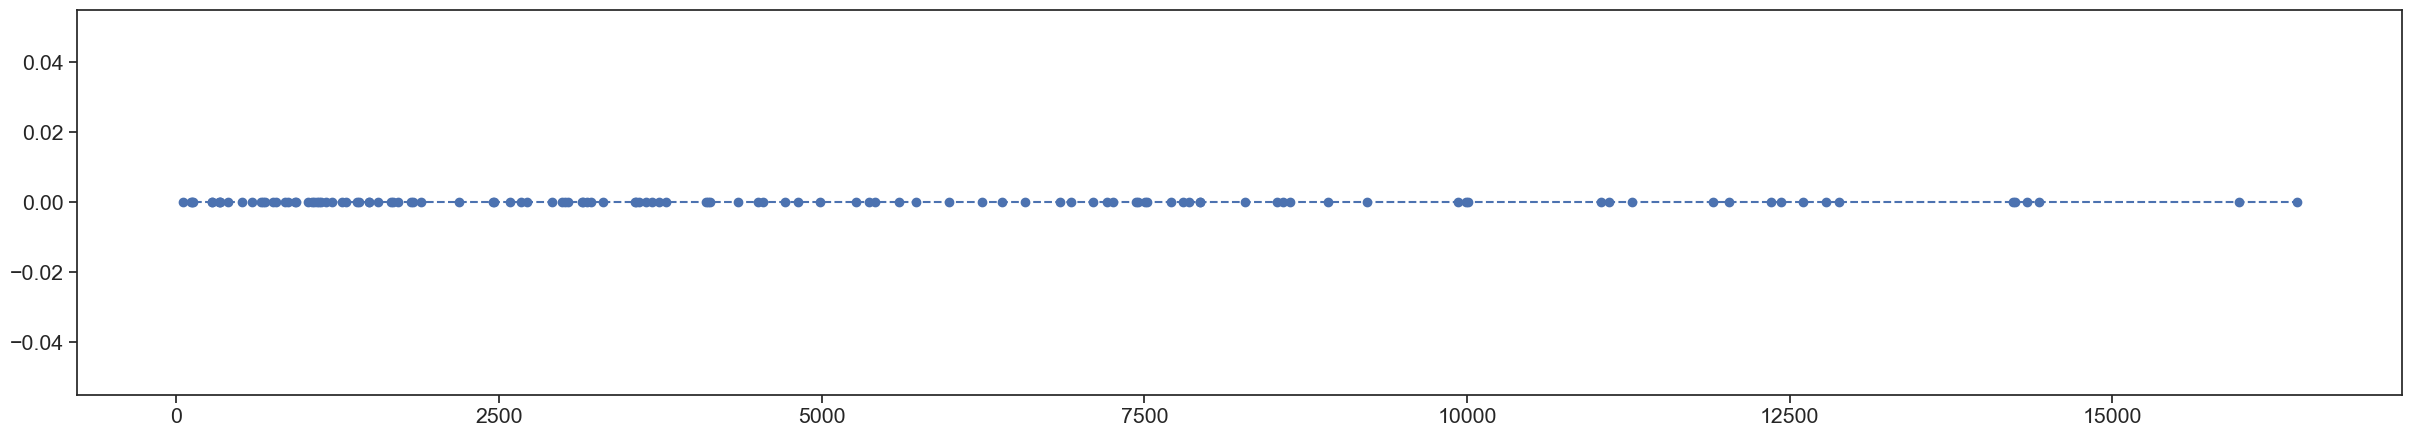

In [422]:
AD_markers_sig = AD_markers[AD_markers["Score_gda"] > 0.2]
df_pred_AD_markers = df_detected_pred[df_detected_pred["Uniprot"].isin(AD_markers_sig["UniProt"])] 
print("Number of associated markers:", len(df_pred_AD_markers))
print("Percent predicted as CSF secreted:", 
    len(df_pred_AD_markers[df_pred_AD_markers["lr_l2"] > 0.5])/len(df_pred_AD_markers))
print("Percent predicted as non-CSF secreted:", 
    len(df_pred_AD_markers[df_pred_AD_markers["lr_l2"] < 0.5])/len(df_pred_AD_markers))

fig, ax = plt.subplots(1, 1, figsize=(30,5))
plt.plot(df_pred_AD_markers.index, np.zeros(len(df_pred_AD_markers.index)), "--bo")
plt.show()

### Dementia (DisGeNet)

Number of dementia markers: 22
Percent predicted as CSF secreted: 0.7272727272727273
Percent predicted as non-CSF secreted: 0.2727272727272727


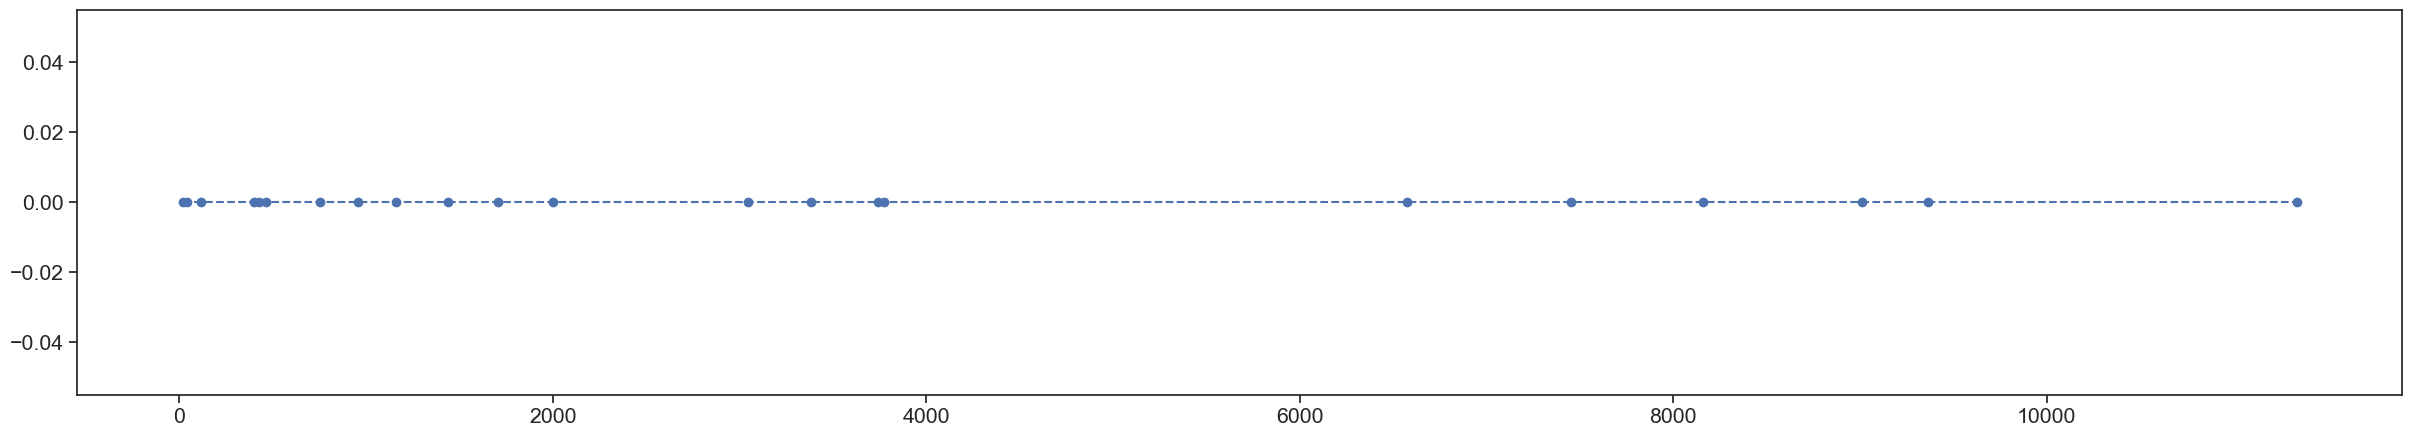

In [423]:
dementia_markers_sig = dementia_markers[dementia_markers["Score_gda"] >= 0.2]
df_pred_dementia_markers = df_detected_pred[df_detected_pred["Uniprot"].isin(dementia_markers_sig["UniProt"])] 
print("Number of dementia markers:", len(df_pred_dementia_markers))
print("Percent predicted as CSF secreted:", 
    len(df_pred_dementia_markers[df_pred_dementia_markers["lr_l2"] > 0.5])/len(df_pred_dementia_markers))
print("Percent predicted as non-CSF secreted:", 
    len(df_pred_dementia_markers[df_pred_dementia_markers["lr_l2"] < 0.5])/len(df_pred_dementia_markers))

fig, ax = plt.subplots(1, 1, figsize=(30,5))
plt.plot(df_pred_dementia_markers.index, np.zeros(len(df_pred_dementia_markers.index)), "--bo")
plt.show() # 0.5 threshold at rank 5943

## Probability scores of known & potential AD CSF biomarkers

Used literature:
- Olsson et al. (2016) CSF and blood biomarkers for the diagnosis of Alzheimer's disease: a systematic review and meta-analysis. https://doi.org/10.1016/S1474-4422(16)00070-3
- Molinuevo et al. (2018) Current state of Alzheimer’s fluid biomarkers. https://doi.org/10.1007/s00401-018-1932-x



In [424]:
# create dictionary of known AD biomarkers
biomarker_dict = {"P05067": "APP", "P10636": "MAPT", "Q92686": "Neurogranin", "Q9NZC2": "TREM2", "P07196": "NFL",
                  "P14136": "GFAP", "P36222": "YKL-40", "P09104": "NSE", "P62760": "VLP-1", "P13500": "MCP-1",
                  "P05413": "HFABP", "P56817": "BACE1", "P02778": "IP-10", "P60880": "SNAP25", "P21579":"Synaptotagmin"}

for biomarker in biomarker_dict.keys():
    print(biomarker_dict[biomarker], "%.04f" % df_detected_pred[df_detected_pred["Uniprot"] == biomarker]["lr_l2"].values[0])
    
    

APP 0.9399
MAPT 0.8630
Neurogranin 0.9503
TREM2 0.6371
NFL 0.5026
GFAP 0.5166
YKL-40 0.8386
NSE 0.6986
VLP-1 0.5631
MCP-1 0.8604
HFABP 0.8884
BACE1 0.8693
IP-10 0.8077
SNAP25 0.7454
Synaptotagmin 0.9083


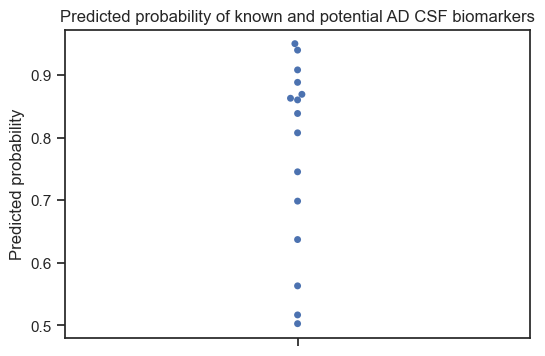

In [425]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.swarmplot(y=df_detected_pred[df_detected_pred["Uniprot"].isin(biomarker_dict.keys())]["lr_l2"], dodge=True)
ax.set(title="Predicted probability of known and potential AD CSF biomarkers", ylabel="Predicted probability")

plt.show()
fig.savefig(fig_path + "Probability_AD_CSF_biomarkers.png", bbox_inches="tight", dpi=300)

### Candidates from MIRIADE consortium

In [426]:
# print("Rank of probability for")
# print("\tCRH:", df_pred[df_pred["Uniprot"] == "P06850"].index[0])
# print("\tMMP1:", df_detected_pred[df_detected_pred["Uniprot"] == "P03956"].index[0])
# print("\tGBA:", df_detected_pred[df_detected_pred["Uniprot"] == "P04062"].index[0])

# print("\tPEBP1:", df_detected_pred[df_detected_pred["Uniprot"] == "P30086"].index[0])
# print("\tSPON1:", df_detected_pred[df_detected_pred["Uniprot"] == "Q9HCB6"].index[0])

# print("\tVAMP2:", df_detected_pred[df_detected_pred["Uniprot"] == "P63027"].index[0])
# print("\tGluR4:", df_detected_pred[df_detected_pred["Uniprot"] == "P48058"].index[0])
# print("\tNPTX2:", df_detected_pred[df_detected_pred["Uniprot"] == "P47972"].index[0])
# print("\tGAP43:", df_detected_pred[df_detected_pred["Uniprot"] == "P17677"].index[0])

# Investigate false positives

These proteins were predicted to be secreted to the CSF but are annotated not to be. One explanation would be that these proteins are secreted to CSF but in such low concentrations that it is not (easily) possible to detect them in exploratory mass spectrometry studies.

In [427]:
# check brain proteins that have not been found in CSF but are predicted to be CSF secreted
df_elevated_FP = df_elevated_non_CSF[df_elevated_non_CSF["lr_l2"] > 0.5]
print("Number of false positive proteins in brain elevated dataset:", len(df_elevated_FP))

df_val_FP = df_val_non_CSF[df_val_non_CSF["lr_l2"] > 0.5]
print("Number of false positive proteins in brain detected validation dataset:", len(df_val_FP))
brain_exp

Number of false positive proteins in brain elevated dataset: 307
Number of false positive proteins in brain detected validation dataset: 1919


,Uniprot,Brain expression,log2(Brain expression)
0,O43612,352.2,8.460251
1,P51861,38856.0,15.245850
2,P01185,5271.0,12.363861
3,Q96PE5,149.9,7.227857
4,Q9BZE3,34.3,5.100137
...,...,...,...
2541,A4D1E1,2.2,1.137504
2542,Q05481,30.4,4.925999
2543,Q8TCW7,1.3,0.378512
2544,Q96LW9,43.6,5.446256


In [428]:
brain_exp_FP = brain_exp.merge(df_elevated_FP[["Uniprot", "lr_l2"]], on="Uniprot", how="inner")
# brain expression values not available for all proteins in brain detected set

print("Average brain expression of false positive proteins in brain elevated dataset: %.04f"
    % np.median(brain_exp_FP["log2(Brain expression)"]))

Average brain expression of false positive proteins in brain elevated dataset: 4.8379


In [429]:
df_elevated_FP["log2(Molecular weight)"] = np.log2(df_elevated_FP["Molecular weight"])
df_elevated_CSF["log2(Molecular weight)"] = np.log2(df_elevated_CSF["Molecular weight"])

print("Average false positive protein size in brain elevated dataset: %.04f"
    % np.median(df_elevated_FP["log2(Molecular weight)"]))
print("Average CSF protein size in brain elevated dataset: %.04f" 
    % np.median(df_elevated_CSF["log2(Molecular weight)"]))

Average false positive protein size in brain elevated dataset: 15.9554
Average CSF protein size in brain elevated dataset: 16.0680


## Check false positively predicted proteins for potential biomarkers

### Low brain expression

In [430]:
# how many proteins are confidently predicted to be in CSF and have a lower than average brain expression?
low_exp_biomarker_candidates = brain_exp_FP[(brain_exp_FP["lr_l2"] > 0.75) & 
    (brain_exp_FP["log2(Brain expression)"] < np.median(brain_exp_CSF["log2(Brain expression)"]))]
print("Number of lowly expressed biomarker candidates:", len(low_exp_biomarker_candidates))

Number of lowly expressed biomarker candidates: 38


In [431]:
low_exp_biomarker_candidates.to_csv(data_path + "Biomarker_discovery/Biomarker_candidates_low_exp.csv", index=False)

In [432]:
with open(data_path + "Biomarker_discovery/Biomarker_candidates_low_exp.txt", "w") as f:
    for item in low_exp_biomarker_candidates["Uniprot"]:
        f.write("%s\n" % item)

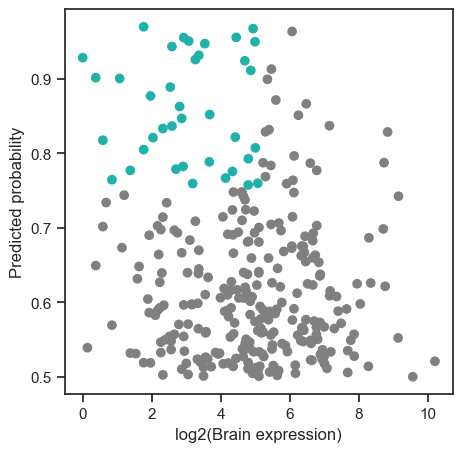

In [433]:
# set which points to colour based on brain expression and probability cut-off
col = np.where((brain_exp_FP["lr_l2"] > 0.75) & 
    (brain_exp_FP["log2(Brain expression)"] < np.median(brain_exp_CSF["log2(Brain expression)"])), 
    "lightseagreen", "grey")

fig, ax = plt.subplots(1, 1, figsize=(5,5))

plt.scatter(x="log2(Brain expression)", y="lr_l2", data=brain_exp_FP, color=col)
ax.set(xlabel="log2(Brain expression)", ylabel="Predicted probability")

plt.show()
fig.savefig(fig_path + "Scatter_false_positives_brain_expression_probability.png", bbox_inches="tight")

### Low molecular weight

In [434]:
# how many proteins are confidently predicted to be in CSF and have a low molecular weight?
low_mw_biomarker_candidates = df_elevated_FP[(df_elevated_FP["lr_l2"] > 0.75) & 
    (df_elevated_FP["log2(Molecular weight)"] < np.median(df_elevated_CSF["log2(Molecular weight)"]))]
print("Number of biomarker candidates:", len(low_mw_biomarker_candidates))

Number of biomarker candidates: 32


In [435]:
with open(data_path + "Biomarker_discovery/Biomarker_candidates_low_mw.txt", "w") as f:
    for item in low_mw_biomarker_candidates["Uniprot"]:
        f.write("%s\n" % item)

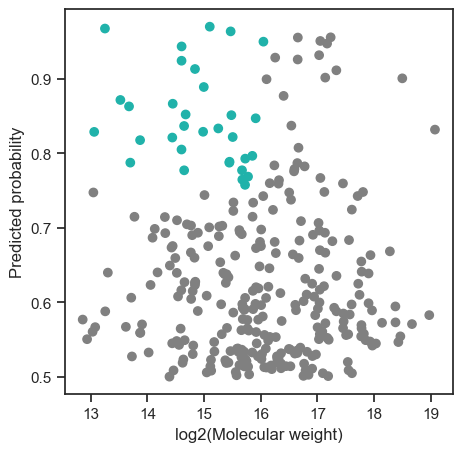

In [436]:
# set which points to colour based on brain expression and probability cut-off
col = np.where((df_elevated_FP["lr_l2"] > 0.75) &
    (df_elevated_FP["log2(Molecular weight)"] < np.median(df_elevated_CSF["log2(Molecular weight)"])), 
    "lightseagreen", "grey")

fig, ax = plt.subplots(1, 1, figsize=(5,5))

plt.scatter(x="log2(Molecular weight)", y="lr_l2", data=df_elevated_FP, color=col)
ax.set(xlabel="log2(Molecular weight)", ylabel="Predicted probability")

plt.show()
fig.savefig(fig_path + "Scatter_false_positives_molecular_weight_probability.png", bbox_inches="tight")

### Compare protein groups

In [437]:
biomarker_candidates = set(low_exp_biomarker_candidates["Uniprot"]).union(set(low_mw_biomarker_candidates["Uniprot"]))

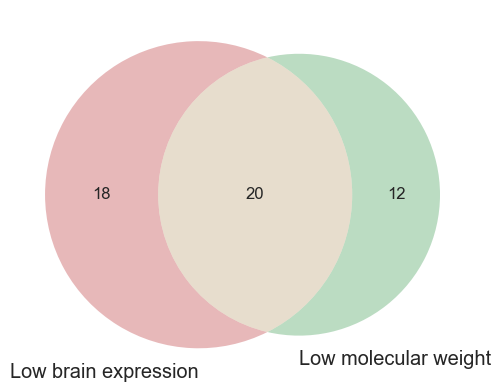

In [438]:
venn2([set(low_exp_biomarker_candidates["Uniprot"]), set(low_mw_biomarker_candidates["Uniprot"])], 
    ["Low brain expression", "Low molecular weight"])

plt.show()

In [439]:
Olink_proteins = pd.read_csv("C:/Users/kathi/Documents/Career/PhD/Data/OLINK_data/Original/Complete Biomarker List (July 1 2019).csv", 
    sep=";", skipfooter=2, engine="python")
Olink_proteins

,Protein,Uniprot ID,Panel(s),Notes
0,(Pyruvate dehydrogenase (acetyl-transferring))...,Q9P0J1,OD,NaN
1,"2,4-dienoyl-CoA reductase, mitochondrial (DECR1)",Q16698,CVD II,NaN
2,26S proteasome non-ATPase regulatory subunit 9...,O00233,Onc III,NaN
3,5'-AMP-activated protein kinase subunit beta-1...,Q9Y478,OD,NaN
4,5'-nucleotidase (5'-NT),P21589,Onc II,NaN
...,...,...,...,...
1156,Xaa-Pro aminopeptidase 2 (XPNPEP2),O43895,Onc II,NaN
1157,YTH domain-containing family protein 3 (YTHDF3),Q7Z739,Onc III,NaN
1158,Zinc finger and BTB domain-containing protein ...,Q05516,"IR, Cell-Reg",NaN
1159,Zinc finger and BTB domain-containing protein ...,Q13105,Cell-Reg,NaN


{'O95727', 'P68106', 'P22466', 'Q9UBT3'}


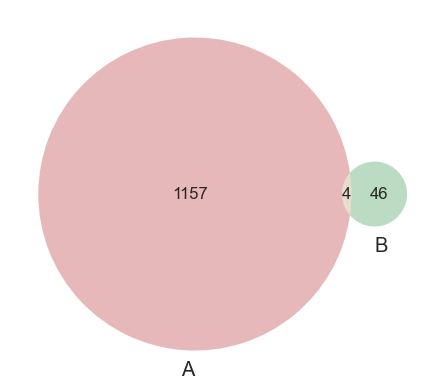

In [440]:
print(set(Olink_proteins["Uniprot ID"]).intersection(biomarker_candidates))

venn2([set(Olink_proteins["Uniprot ID"]), biomarker_candidates])
plt.show()

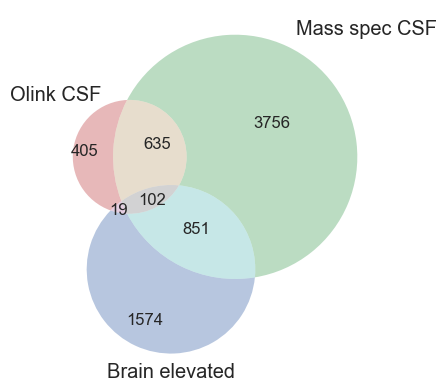

In [441]:
venn3([set(Olink_proteins["Uniprot ID"]), set(csf["Uniprot"]), set(brain_elevated["Uniprot"])], ["Olink CSF", "Mass spec CSF",
    "Brain elevated"])
plt.show()

In [442]:
biomarker_candidates_olink = set(Olink_proteins["Uniprot ID"]).intersection(set(brain_elevated["Uniprot"])) - set(csf["Uniprot"])
print("Proteins identified only in Olink CSF study:", len(biomarker_candidates_olink))

Proteins identified only in Olink CSF study: 19


In [443]:
for i in biomarker_candidates_olink:
    print(i)

O95727
Q13574
O76038
P0CG37
Q8N5S9
Q9Y2J8
P01135
Q9Y5L3
P50749
P68106
O00253
Q01344
Q9UBT3
P20273
Q92558
P05113
O60542
P22466
Q9GZV9


In [444]:
np.median(df_pred[df_pred["Uniprot"].isin(biomarker_candidates_olink)]["lr_l2"])

0.49730567894458333

In [445]:
df_pred[df_pred["Uniprot"].isin(biomarker_candidates_olink)]

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PS00028,PS00022,PS01186,CSF,lr_l2,lr_l2_2plus,lr_l2_3plus,lr_l1,lr_l1_2plus,lr_l1_3plus
1085,P68106,MGVEIETISPGDGRTFPKKGQTCVVHYTGMLQNGKKFDSSRDRNKP...,108,11782.3744,0.055556,0.018519,0.046296,0.064815,0.055556,0.120370,...,0,0,0,-1,0.871625,0.743528,0.708212,0.808798,0.589008,0.423030
1434,P20273,MHLLGPWLLLLVLEYLAFSDSSKWVFEHPETLYAWEGACVWIPCTY...,847,95346.5749,0.041322,0.027155,0.040142,0.068477,0.028335,0.063754,...,0,0,0,-1,0.837166,0.087935,0.218389,0.855082,0.066801,0.071487
1813,Q9UBT3,MVAAVLLGLSWLCSPLGALVLDFNNIRSSADLHGARKGSQCLSDTD...,224,24875.4361,0.058036,0.093750,0.058036,0.049107,0.026786,0.080357,...,0,0,0,-1,0.805099,0.121782,0.137711,0.760315,0.154902,0.155612
1996,P22466,MARGSALLLASLLLAAALSASAGLWSPAKEKRGWTLNSAGYLLGPH...,123,13301.9928,0.130081,0.000000,0.056911,0.065041,0.032520,0.073171,...,0,0,0,-1,0.787482,0.061639,0.068975,0.614006,0.111039,0.158678
1997,O95727,MWWRVLSLLAWFPLQEASLTNHTETITVEEGQTLTLKCVTSLRKNS...,393,44640.2599,0.033079,0.015267,0.030534,0.091603,0.027990,0.035623,...,0,0,0,-1,0.787425,0.067342,0.201789,0.803613,0.062687,0.093572
2897,Q9GZV9,MLGARLRLWVCALCSVCSMSVLRAYPNASPLLGSSWGGLIHLYTAT...,251,27953.5401,0.075697,0.027888,0.039841,0.035857,0.043825,0.079681,...,0,0,0,-1,0.703037,0.027857,0.026706,0.578175,0.078212,0.051694
5649,Q9Y5L3,MAGKVRSLLPPLLLAAAGLAGLLLLCVPTRDVREPPALKYGIVLDA...,495,53664.8455,0.101010,0.022222,0.040404,0.026263,0.054545,0.090909,...,0,0,0,-1,0.513860,0.070716,0.101103,0.482115,0.095890,0.096664
5937,P01135,MVPSAGQLALFALGIVLAACQALENSTSPLSADPPVAAAVVSHFND...,160,17005.8365,0.143750,0.093750,0.031250,0.037500,0.031250,0.037500,...,0,0,0,-1,0.497306,0.019360,0.019844,0.562921,0.036621,0.044758
6029,Q9Y2J8,MLRERTVRLQYGSRVEAVYVLGTYLWTDVYSAAPAGAQTFSLKHSE...,665,75563.0625,0.042105,0.019549,0.063158,0.073684,0.054135,0.070677,...,0,0,0,-1,0.492369,0.330856,0.302217,0.559283,0.276440,0.228990
6335,P50749,MDYSHQTSLVPCGQDKYISKNELLLHLKTYNLYYEGQNLQLRHREE...,326,37789.7530,0.030675,0.009202,0.046012,0.082822,0.027607,0.046012,...,0,0,0,-1,0.474822,0.237359,0.283662,0.514793,0.268192,0.281004


# Investigate false negatives

These proteins were predicted to not be secreted to the CSF but are annotated to be. One explanation would be that these proteins are actually false positives in the CSF mass spectrometry studies. False positive proteins are likely only found in only one study and with only one peptide.

In [446]:
df_elevated_FN = df_elevated_CSF[df_elevated_CSF["lr_l2"] < 0.5]
print("Number of false negative proteins in brain elevated dataset:", len(df_elevated_FN))

Number of false negative proteins in brain elevated dataset: 241


## Check maximum peptide count of false negatives vs. all positive CSF proteins 

In [447]:
csf["#Peptides_max"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010"]].max(axis=1)

csf_2plus = csf[csf["#Studies"] >= 2]
csf_3plus = csf[csf["#Studies"] >= 3]

### All CSF proteins

In [448]:
df_elevated_FN

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PS00022,PS01186,CSF,lr_l2,lr_l2_2plus,lr_l2_3plus,lr_l1,lr_l1_2plus,lr_l1_3plus,log2(Molecular weight)
5898,Q9NZR1,MALPFQKELEKYKNIDEDELLGKLSEEELKQLENVLDDLDPESAML...,351,39594.5525,0.079772,0.000000,0.056980,0.116809,0.039886,0.042735,...,0,0,1,0.499842,0.879246,0.770990,0.422254,0.688113,0.558686,15.273014
5948,P22676,MAGPQQQPPYLHLAELTASQFLEIWKHFDADGNGYIEGKELENFFQ...,271,31539.5167,0.055351,0.007380,0.062731,0.110701,0.059041,0.062731,...,0,0,1,0.496693,0.598468,0.255880,0.491963,0.471272,0.335070,14.944873
5955,Q9Y3Q8,MSGGKKKSSFQITSVTTDYEGPGSPGASDPPTPQPPTGPPPRLPNG...,395,41025.5313,0.086076,0.002532,0.040506,0.065823,0.020253,0.118987,...,0,0,1,0.496134,0.235810,0.298689,0.506322,0.289121,0.376249,15.324234
5964,Q8WZ64,MSSVSEVNVDIKDFLMSINLEQYLLHFHESGFTTVKDCAAINDSLL...,1704,193449.5224,0.054577,0.018192,0.055751,0.079225,0.041667,0.044601,...,0,0,1,0.495685,0.263672,0.236944,0.503048,0.262532,0.297420,17.561598
5966,Q6U841,MEIKDQGAQMEPLLPTRNDEEAVVDRGGTRSILKTHFEKEDLEGHR...,1118,125944.8139,0.055456,0.018784,0.052773,0.073345,0.050984,0.066190,...,0,0,1,0.495633,0.606075,0.559749,0.416903,0.882892,0.871719,16.942432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15111,Q9BSW7,MAYIQLEPLNEGFLSRISGLLLCRWTCRHCCQKCYESSCCQSSEDE...,474,53848.4521,0.031646,0.023207,0.059072,0.063291,0.040084,0.044304,...,0,0,1,0.104326,0.061652,0.126962,0.160091,0.104321,0.131085,15.716617
15292,Q9BQI9,MLFIFPLSLPWRPSCWKESCSTGQRQAGRSREDSVTPPPSSPWPTP...,281,31330.4460,0.064057,0.032028,0.046263,0.067616,0.021352,0.064057,...,0,0,1,0.096589,0.113827,0.259644,0.181870,0.137051,0.247463,14.935278
15699,P23610,MAAAAAGLGGGGAGPGPEAGDFLARYRLVSNKLKKRFLRKPNVAEA...,371,39102.5606,0.183288,0.018868,0.018868,0.067385,0.026954,0.078167,...,0,0,1,0.081386,0.306486,0.159102,0.102044,0.242240,0.234182,15.254975
15786,Q8NBL3,MEPRALVTALSLGLSLCSLGLLVTAIFTDHWYETDPRRHKESCERS...,297,33018.1524,0.077441,0.040404,0.047138,0.033670,0.043771,0.080808,...,0,0,1,0.077788,0.045806,0.024767,0.179057,0.099450,0.124129,15.010972


Fraction of proteins identified with only one matching peptide in false negatives: 0.4108
Fraction of proteins identified with only one matching peptide in all CSF proteins: 0.1973


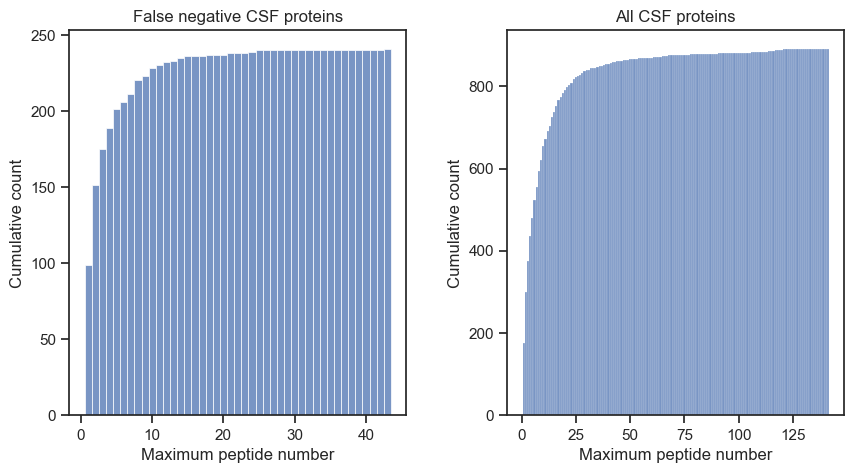

In [449]:
df_elevated_FN_peptides = df_elevated_FN[["Uniprot"]].merge(csf[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")
df_elevated_CSF_peptides = df_elevated_CSF[["Uniprot"]].merge(csf[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")

print("Fraction of proteins identified with only one matching peptide in false negatives: %.04f" 
    % (len(df_elevated_FN_peptides[df_elevated_FN_peptides["#Peptides_max"] == 1])/len(df_elevated_FN_peptides)))
print("Fraction of proteins identified with only one matching peptide in all CSF proteins: %.04f" 
    % (len(df_elevated_CSF_peptides[df_elevated_CSF_peptides["#Peptides_max"] == 1])/len(df_elevated_CSF_peptides)))

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.histplot(data=df_elevated_FN_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[0])
ax[0].set(title="False negative CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")
sns.histplot(data=df_elevated_CSF_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[1])
ax[1].set(title="All CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")

plt.show()
fig.savefig(fig_path + "Hist_cumulative_count_max_peptides.png", bbox_inches="tight")

### 2+ studies CSF proteins

Fraction of proteins identified with only one matching peptide in false negatives: 0.1053
Fraction of proteins identified with only one matching peptide in all CSF proteins: 0.0447


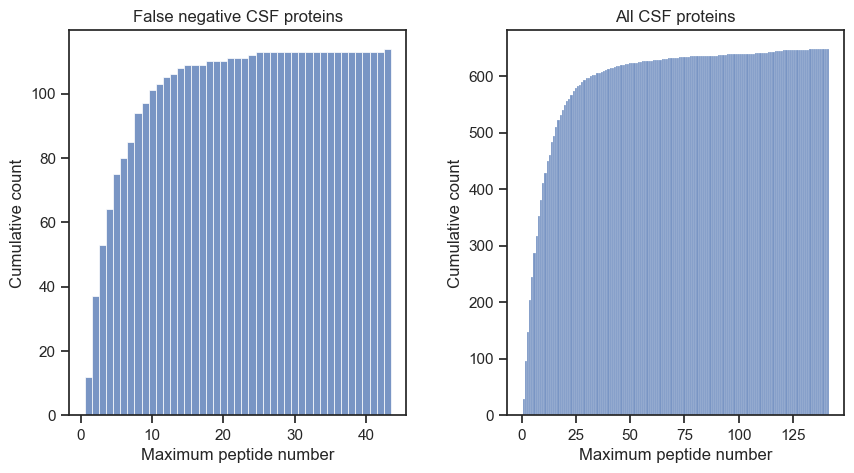

In [450]:
csf_2plus_FN_peptides = df_elevated_FN[["Uniprot"]].merge(csf_2plus[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")
csf_2plus_CSF_peptides = df_elevated_CSF[["Uniprot"]].merge(csf_2plus[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")

print("Fraction of proteins identified with only one matching peptide in false negatives: %.04f" 
    % (len(csf_2plus_FN_peptides[csf_2plus_FN_peptides["#Peptides_max"] == 1])/len(csf_2plus_FN_peptides)))
print("Fraction of proteins identified with only one matching peptide in all CSF proteins: %.04f" 
    % (len(csf_2plus_CSF_peptides[csf_2plus_CSF_peptides["#Peptides_max"] == 1])/len(csf_2plus_CSF_peptides)))

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.histplot(data=csf_2plus_FN_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[0])
ax[0].set(title="False negative CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")
sns.histplot(data=csf_2plus_CSF_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[1])
ax[1].set(title="All CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")

plt.show()
fig.savefig(fig_path + "Hist_cumulative_count_max_peptides_2plus.png", bbox_inches="tight")

### 3+ studies CSF proteins

Fraction of proteins identified with only one matching peptide in false negatives: 0.0139
Fraction of proteins identified with only one matching peptide in all CSF proteins: 0.0038


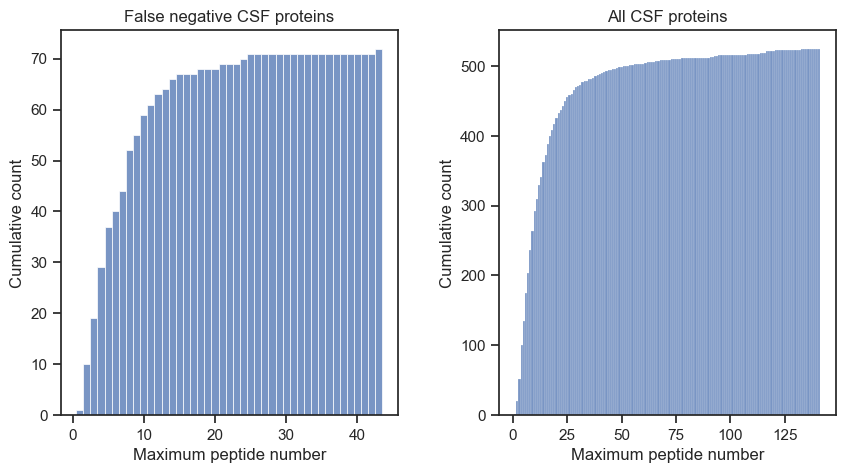

In [451]:
csf_3plus_FN_peptides = df_elevated_FN[["Uniprot"]].merge(csf_3plus[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")
csf_3plus_CSF_peptides = df_elevated_CSF[["Uniprot"]].merge(csf_3plus[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")

print("Fraction of proteins identified with only one matching peptide in false negatives: %.04f" 
    % (len(csf_3plus_FN_peptides[csf_3plus_FN_peptides["#Peptides_max"] == 1])/len(csf_3plus_FN_peptides)))
print("Fraction of proteins identified with only one matching peptide in all CSF proteins: %.04f" 
    % (len(csf_3plus_CSF_peptides[csf_3plus_CSF_peptides["#Peptides_max"] == 1])/len(csf_3plus_CSF_peptides)))

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.histplot(data=csf_3plus_FN_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[0])
ax[0].set(title="False negative CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")
sns.histplot(data=csf_3plus_CSF_peptides, x="#Peptides_max", discrete=True, cumulative=True, ax=ax[1])
ax[1].set(title="All CSF proteins", xlabel="Maximum peptide number", ylabel="Cumulative count")

plt.show()
fig.savefig(fig_path + "Hist_cumulative_count_max_peptides_3plus.png", bbox_inches="tight")

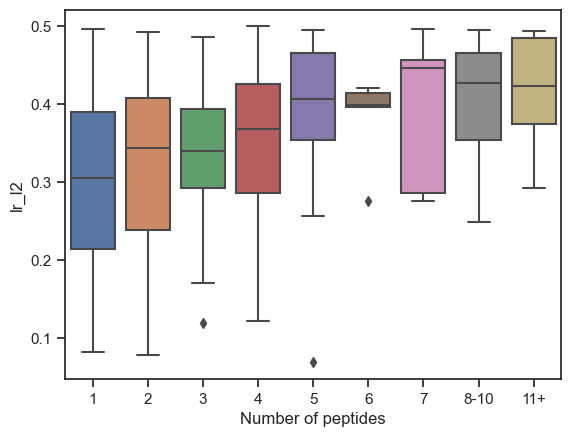

In [452]:
def peptide_category(number):
    if number == 0:
        return "0"
    if number == 1:
        return "1"
    if number == 2:
        return "2"
    if number == 3:
        return "3"
    if number == 4:
        return "4"
    if number == 5:
        return "5"
    if number == 6:
        return "6"
    if number == 7:
        return "7"
    if 7 < number < 10:
        return "8-10"
    if number >= 11:
        return "11+"

df_elevated_FN_peptides_proba = df_elevated_FN[["Uniprot", "lr_l2"]].merge(csf[["Uniprot", "#Peptides_max"]], on="Uniprot", how="inner")
df_elevated_FN_peptides_proba["Number of peptides"] = df_elevated_FN_peptides_proba["#Peptides_max"].apply(peptide_category)

sns.boxplot(x="Number of peptides",  y="lr_l2", data=df_elevated_FN_peptides_proba,
            order=["1", "2", "3", "4", "5", "6", "7", "8-10", "11+"])
plt.show()

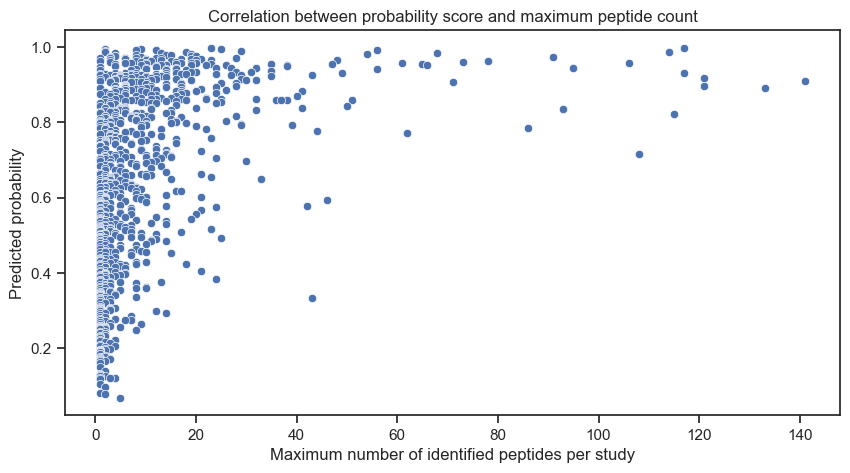

In [453]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

CSF_proba_peptides = df_elevated_CSF[["Uniprot", "lr_l2"]].merge(csf[["Uniprot", "#Peptides_max"]])
sns.scatterplot(y="lr_l2", x="#Peptides_max", data=CSF_proba_peptides)
ax.set(title="Correlation between probability score and maximum peptide count", 
          xlabel="Maximum number of identified peptides per study", ylabel="Predicted probability")

plt.show()
fig.savefig(fig_path + "Scatter_max_peptides_probability.png", bbox_inches="tight")

# Check brain exclusive proteins

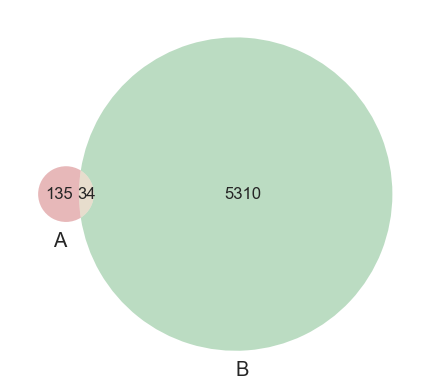

In [454]:
venn2([set(brain_exclusive["Uniprot"]), set(csf["Uniprot"])])
plt.show()

In [455]:
csf_brain_exclusive = csf[csf["Uniprot"].isin(brain_exclusive["Uniprot"])]
csf_brain_exclusive_2plus = csf_brain_exclusive[csf_brain_exclusive["#Studies"] > 1]

In [456]:
df_pred_brain_exclusive = df_pred[df_pred["Uniprot"].isin(csf_brain_exclusive_2plus["Uniprot"])]
(df_pred_brain_exclusive["lr_l2"] > 0.5).sum()/len(df_pred_brain_exclusive)
# np.median(df_pred_brain_exclusive["lr_l2"])

0.8461538461538461

# Nerea's biomarker candidates [MIRIADE]

In [457]:
df_pred_biomarkers_Nerea = df_pred[df_pred["Uniprot"].isin(biomarkers_Nerea["Uniprot"])]
print("Average predicted probability:", (df_pred_biomarkers_Nerea["lr_l2_3plus"] > 0.5).sum()/len(df_pred_biomarkers_Nerea))

Average predicted probability: 0.18996415770609318


In [458]:
biomarkers_Nerea_pred = biomarkers_Nerea.merge(df_pred[["Uniprot", "lr_l2", "lr_l2_3plus"]], on="Uniprot", how="left")
biomarkers_Nerea_pred

,Uniprot,Gene name,Protein name,lr_l2,lr_l2_3plus
0,Q9Y6Q6,TNFRSF11A,TNR11,0.880753,0.209707
1,Q9Y653,ADGRG1,AGRG1,0.470381,0.157422
2,Q9Y624,F11R,JAM1,0.901094,0.351747
3,Q9Y336,SIGLEC9,SIGL9,0.806470,0.192879
4,Q9Y2T3,GDA,GUAD,0.333298,0.156006
...,...,...,...,...,...
285,O00300,TNFRSF11B,TR11B,0.708686,0.109398
286,O00253,AGRP,AGRP,NaN,NaN
287,P02748,C9,CO9,0.934019,0.225925
288,P01011,SERPINA3,AACT,0.827031,0.471196


In [459]:
biomarkers_Nerea_pred.to_excel(data_path + "Biomarker_discovery/Biomarkers_Nerea_predictions.xlsx", index=False)

### Prediction on full human proteome

In [460]:
df_all

# drop non-sequence-based features
df_all.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

# drop AA physicochemical features
df_all.drop(['Polar', 'Neutral', 'Hydrophobic', 'Volume_small', 'Volume_medium', 'Volume_large', 'Polarity_low', 
    'Polarity_medium', 'Polarity_large', 'Polarizability_low', 'Polarizability_medium', 'Polarizability_large',
    'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried', 'Exposed', 'Intermediate'], 
    axis=1, inplace=True)

In [461]:
# define variables and target
X = df_all.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_all["CSF"]

# preprocess data with same scaler as training data
X_scal = X.copy()
X_scal[cont] = scaler.transform(X_scal[cont])

# lr_l2.classes_ # -1 and 1

In [462]:
X_scal

,Length,Molecular weight,A,C,D,E,F,G,H,I,...,First60ExpAA,PredHel,PredHel_binary,GPI-anchor,PS00232,PS00237,PS00027,PS00028,PS00022,PS01186
0,-0.826150,-0.828130,1.718596,-0.943877,-0.290423,-0.686403,-1.571835,0.588691,0.560419,0.016279,...,-0.004283,-0.150829,1,0,0,0,0,0,0,0
1,0.708655,0.698031,-0.417625,-0.610070,-0.049358,-0.651257,-1.349254,-0.316930,-0.239055,-0.540703,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
2,-0.924497,-0.913763,-0.486519,1.182438,-0.389101,1.718519,0.889231,-0.646340,-0.325497,-0.065646,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
3,-0.377629,-0.400479,0.653072,0.238985,-0.843700,0.599058,-0.998796,0.043931,0.886584,-1.360349,...,2.215353,-0.150829,1,1,0,0,0,0,0,0
4,-0.462565,-0.451741,-0.516860,-0.871011,0.411502,0.944404,-0.963543,0.049480,-0.425200,1.252827,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20298,-0.692041,-0.682441,-0.193228,-0.600497,-0.262229,-0.751456,-1.107612,-0.093252,3.091607,1.093012,...,-0.427363,-0.473647,0,0,0,0,0,0,0,0
20299,-0.307594,-0.320712,-0.414059,-0.256495,-0.295067,0.602026,-1.000632,0.583467,0.778490,-1.236696,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
20300,0.297387,0.306123,-0.065153,-1.248271,-0.610156,4.941589,-1.592703,-0.517087,-0.526368,-0.538953,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
20301,-0.920026,-0.914830,2.105701,-0.708553,-1.115728,-1.017581,-0.459686,0.750166,-1.273365,-1.205153,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0


In [463]:
df_all_pred = df_all.copy()
models = [lr_l2, lr_l2_2plus, lr_l2_3plus]
model_names = ["lr_l2", "lr_l2_2plus", "lr_l2_3plus", "lr_l1", "lr_l1_2plus", "lr_l1_3plus"]
# models = [svc_l2, svc_l2_2plus, svc_l2_3plus]
# model_names = ["svc_l2", "svc_l2_2plus", "svc_l2_3plus"]

for i, m in enumerate(models):
    # calculate probabilities with trained model
    proba = m.predict_proba(X_scal)
#     proba = m.decision_function(X_scal)
    # create dataframe of probabilities
    preds = pd.DataFrame(proba, columns=["non_CSF_proba", "CSF_proba"])
    column_name = model_names[i]
    df_all_pred[column_name] = preds["CSF_proba"]

# order dataframe by probabilities
df_all_pred.sort_values(by="lr_l2", ascending=False, inplace=True)
# reindex to see protein rank according to probability
df_all_pred.reset_index(drop=True, inplace=True)

df_all_pred[:50]

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.



,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PS00232,PS00237,PS00027,PS00028,PS00022,PS01186,CSF,lr_l2,lr_l2_2plus,lr_l2_3plus
0,Q156A1,MQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ...,80,1.027142e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,-1,0.999990,0.996336,0.999963
1,Q7Z5P9,MKLILWYLVVALWCFFKDVEALLYRQKSDGKIAASRSGGFSYGSSS...,8384,8.052433e+05,0.084566,0.015983,0.018488,0.054031,0.014671,0.176885,...,0,0,0,0,0,0,1,0.999741,0.998978,0.995029
2,Q8WXI7,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,14507,1.519157e+06,0.054388,0.002482,0.031433,0.055628,0.021783,0.051837,...,0,0,0,0,0,0,1,0.999573,0.972055,0.403945
3,P37840,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,140,1.445999e+04,0.135714,0.000000,0.042857,0.128571,0.014286,0.128571,...,0,0,0,0,0,0,1,0.999091,0.981174,0.990145
4,Q09666,MEKEETTRELLLPNWQGSGSHGLTIAQRDDGVFVQEVTQNSPAART...,5890,6.290940e+05,0.035823,0.001528,0.103226,0.059083,0.025806,0.108829,...,0,0,0,0,0,0,1,0.998928,0.969827,0.903149
5,Q8IVF2,MCDCFHMVLPTWPGTPGSVSGRQLQPGEPGAETEDDHSVTEGPADE...,5795,6.166222e+05,0.075237,0.003451,0.082140,0.072476,0.025712,0.080414,...,0,0,0,0,0,0,1,0.998476,0.933391,0.849080
6,E2RYF6,MRRGNISPAFWFLWLLLFGLLGPSSENTTAFTKGSDTTTASITGSE...,1773,1.734758e+05,0.089679,0.002256,0.011844,0.094191,0.013536,0.094191,...,0,0,0,0,0,0,-1,0.998432,0.967143,0.996161
7,Q5VST9,MDQPQFSGAPRFLTRPKAFVVSVGKDATLSCQIVGNPTPQVSWEKD...,7968,8.684737e+05,0.103539,0.025728,0.044177,0.087726,0.024724,0.074674,...,0,0,0,0,0,0,1,0.998201,0.945829,0.629000
8,Q15847,MASKGLQDLKQQVEGTAQEAVSAAGAAAQQVVDQATEAGQKAMDQL...,76,7.854663e+03,0.184211,0.000000,0.065789,0.052632,0.026316,0.092105,...,0,0,0,0,0,0,1,0.998072,0.912494,0.967897
9,Q8TDW7,MDIIMGHCVGTRPPACCLILLLFKLLATVSQGLPGTGPLGFHFTHS...,4557,5.019721e+05,0.054641,0.013386,0.074172,0.060347,0.041914,0.064077,...,1,0,0,0,1,1,1,0.996874,0.993297,0.985014


In [464]:
df_all_pred.loc[1][25:]

Instability index        24.058447
Solubility                0.759091
Disorder_NSP              0.033516
Helix_NSP                 0.024094
Turn_NSP                  0.597686
Sheet_NSP                  0.37822
Signal peptide                   1
Glycosylation                  0.0
GlycoMine_N                      1
GlycoMine_O                      1
GlycoMine_C                      0
Cytoplasm                        0
Extracellular                    1
Lysosome/Vacuole                 0
Nucleus                          0
Cell_membrane                    0
Endoplasmic_reticulum            0
Mitochondrion                    0
Golgi_apparatus                  0
Peroxisome                       0
Plastid                          0
ExpAA                          0.0
First60ExpAA                   0.0
PredHel                        0.0
PredHel_binary                   0
GPI-anchor                       0
PS00232                          0
PS00237                          0
PS00027             

In [465]:
X_scal

,Length,Molecular weight,A,C,D,E,F,G,H,I,...,First60ExpAA,PredHel,PredHel_binary,GPI-anchor,PS00232,PS00237,PS00027,PS00028,PS00022,PS01186
0,-0.826150,-0.828130,1.718596,-0.943877,-0.290423,-0.686403,-1.571835,0.588691,0.560419,0.016279,...,-0.004283,-0.150829,1,0,0,0,0,0,0,0
1,0.708655,0.698031,-0.417625,-0.610070,-0.049358,-0.651257,-1.349254,-0.316930,-0.239055,-0.540703,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
2,-0.924497,-0.913763,-0.486519,1.182438,-0.389101,1.718519,0.889231,-0.646340,-0.325497,-0.065646,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
3,-0.377629,-0.400479,0.653072,0.238985,-0.843700,0.599058,-0.998796,0.043931,0.886584,-1.360349,...,2.215353,-0.150829,1,1,0,0,0,0,0,0
4,-0.462565,-0.451741,-0.516860,-0.871011,0.411502,0.944404,-0.963543,0.049480,-0.425200,1.252827,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20298,-0.692041,-0.682441,-0.193228,-0.600497,-0.262229,-0.751456,-1.107612,-0.093252,3.091607,1.093012,...,-0.427363,-0.473647,0,0,0,0,0,0,0,0
20299,-0.307594,-0.320712,-0.414059,-0.256495,-0.295067,0.602026,-1.000632,0.583467,0.778490,-1.236696,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
20300,0.297387,0.306123,-0.065153,-1.248271,-0.610156,4.941589,-1.592703,-0.517087,-0.526368,-0.538953,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0
20301,-0.920026,-0.914830,2.105701,-0.708553,-1.115728,-1.017581,-0.459686,0.750166,-1.273365,-1.205153,...,-0.515658,-0.473647,0,0,0,0,0,0,0,0


In [466]:
import shap

my_model = lr_l2

explainer = shap.Explainer(my_model, )


choosen_instance = df_all_pred.loc[[0]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance, plot_cmap=["#FF5733","#335BFF"])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression(C=1, max_iter=1000, random_state=0)

In [ ]:
# explainer = shap.Explainer(lr_l2, X_train, feature_names=vectorizer.get_feature_names())
explainer = shap.explainers.Linear(lr_l2, X_train, feature_names=vectorizer.get_feature_names())
shap_values = explainer(X_test)